In [186]:
# import required libraries

import pandas as pd
import numpy as np
from sklearn.preprocessing import OrdinalEncoder
from sklearn.preprocessing import OneHotEncoder
from sklearn.feature_selection import mutual_info_classif
from sklearn.model_selection import train_test_split
from sklearn.metrics import recall_score, precision_score, f1_score, roc_auc_score, confusion_matrix, roc_curve, roc_auc_score, ConfusionMatrixDisplay, accuracy_score
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from imblearn.over_sampling import RandomOverSampler
from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import SMOTE
from imblearn.over_sampling import BorderlineSMOTE
from imblearn.under_sampling import TomekLinks
from sklearn.decomposition import PCA
from sklearn.model_selection import GridSearchCV
from matplotlib import pyplot as plt
import seaborn as sns
from sklearn.model_selection import cross_val_score
from sklearn.inspection import permutation_importance
import category_encoders as ce


<a name="driver table"></a>

In [79]:
# driver table

# read gpv_amnt_2.csv (query_1 result) as txn table
txn=pd.read_csv("C:/Users/nhosseinidehaj/Fraud ML/Phase2/Data/feature_list/CNP_JantoJul2023/gpv_amnt_2.csv")
# convert txn_date column to datetime
txn['txn_date'] = pd.to_datetime(txn['txn_date'], format="%Y-%m-%d")

# extract the driver table from the txn table by setting limitation on txn_date (here from 2023-01-01 to 2023-07-31)
driver = txn[(txn['txn_date']>="2023-01-01") & (txn['txn_date']<"2023-08-01")]
# make sure there are no duplicated transaction
print(driver.shape)
print(driver.tender_id.nunique())

(1884676, 5)
1884676


<a name="gpv features"></a>

In [23]:
%%time
# Build gpv features (except for the lifetime gpv features)
# Note because I need 14day, 7day, 3day, 1day gpv features, the txn table has its txn_date 14days before the start date of the driver table
# Note the way I do rolling here, excludes the last txn date in the interval (i.e. the current txn) and includes the first txn date in the interval

# keep a copy of the txn table
gpv = txn.copy()
# set the index of the dataframe to the txn_date column
gpv = gpv.set_index('txn_date')

# sort dataframe by business_uuid and txn_date
gpv = gpv.sort_values(['business_uuid', 'txn_date'])

# calculate gpv (both $ and #) for each business_uuid at the time of each transaction over last 14 days
gpv['gpv_amnt_14'] = gpv.groupby('business_uuid')['txn_amnt'].rolling('14D', closed='left').sum().reset_index(level=0, drop=True) # If 'left', the last point in the window is excluded from calculations.
gpv['gpv_count_14'] = gpv.groupby('business_uuid')['tender_id'].rolling('14D', closed='left').count().reset_index(level=0, drop=True)

# calculate gpv (both $ and #) for each business_uuid at the time of each transaction over last 7 days
gpv['gpv_amnt_7'] = gpv.groupby('business_uuid')['txn_amnt'].rolling('7D', closed='left').sum().reset_index(level=0, drop=True)
gpv['gpv_count_7'] = gpv.groupby('business_uuid')['tender_id'].rolling('7D', closed='left').count().reset_index(level=0, drop=True)

# calculate gpv (both $ and #) for each business_uuid at the time of each transaction over last 3 days
gpv['gpv_amnt_3'] = gpv.groupby('business_uuid')['txn_amnt'].rolling('3D', closed='left').sum().reset_index(level=0, drop=True)
gpv['gpv_count_3'] = gpv.groupby('business_uuid')['tender_id'].rolling('3D', closed='left').count().reset_index(level=0, drop=True)

# calculate gpv (both $ and #) for each business_uuid at the time of each transaction over last 1 day
gpv['gpv_amnt_1'] = gpv.groupby('business_uuid')['txn_amnt'].rolling('1D', closed='left').sum().reset_index(level=0, drop=True)
gpv['gpv_count_1'] = gpv.groupby('business_uuid')['tender_id'].rolling('1D', closed='left').count().reset_index(level=0, drop=True)

# reset the index
gpv = gpv.reset_index()

# keep the resulting table only for the driver population (in this example from 2023-01-01 to 2023-07-31)
gpv = gpv[(gpv['txn_date']>="2023-01-01") & (gpv['txn_date']<"2023-08-01")]
gpv.sort_values(by="txn_date")

CPU times: total: 20.4 s
Wall time: 20.4 s


,txn_date,business_uuid,txn_uuid,tender_id,txn_amnt,gpv_amnt_14,gpv_count_14,gpv_amnt_7,gpv_count_7,gpv_amnt_3,gpv_count_3,gpv_amnt_1,gpv_count_1
575894,2023-01-01 00:00:13,563381a9-9280-463f-abc7-0e6674c170ac,c9e5616f-50d0-4a25-98b9-dda96a044479,992245857,147.79,7851.38,136.0,5349.53,82.0,1856.61,31.0,779.92,13.0
60748,2023-01-01 00:00:20,08149e52-248a-4e15-aac1-2c286a1bae8c,7a6e55a2-d899-4969-8de6-f23d9fec5022,992245993,17.00,13837.50,625.0,7416.00,352.0,3581.50,158.0,1112.50,46.0
1460537,2023-01-01 00:00:25,ceff3c24-a0e8-40a5-b764-e3c28867fd5b,4b8de6c8-a03d-49fd-879e-4180a06328bd,992246098,24.99,220531.88,8818.0,106527.46,4257.0,46351.46,1855.0,16018.59,641.0
1460538,2023-01-01 00:00:33,ceff3c24-a0e8-40a5-b764-e3c28867fd5b,c0bd506d-1d90-4909-9db1-b66338fa57d6,992246265,24.99,220556.87,8819.0,106552.45,4258.0,46376.45,1856.0,16043.58,642.0
1460539,2023-01-01 00:00:46,ceff3c24-a0e8-40a5-b764-e3c28867fd5b,1afce217-8013-4a23-89f6-1201b1ce81c7,992246505,24.99,220581.86,8820.0,106577.44,4259.0,46401.44,1857.0,16068.57,643.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
114976,2023-07-31 23:59:32,0e8a7222-ce4f-40b3-a06d-44a2a88e431a,ba1aee4b-d209-4a9d-80ac-1967bd819c08,1133497886,89.96,21382.94,142.0,7752.26,36.0,1244.10,7.0,749.97,4.0
693339,2023-07-31 23:59:35,67555d52-d61b-4092-8724-dbd476aac08a,2709a0db-baeb-4a8f-958d-2d7d033ac0b7,1133497904,175.00,12295.00,161.0,7836.00,112.0,4120.00,54.0,1065.00,9.0
409767,2023-07-31 23:59:48,3e64ab9a-e296-4cc2-8d44-1138192e3d1f,aea83a7a-3258-4331-a790-a20e78379d83,1133498036,1009.00,6182.13,10.0,3357.00,5.0,2162.00,2.0,2162.00,2.0
1324427,2023-07-31 23:59:50,c09bf5f8-7267-42b7-8fdb-62dc3005d007,40a9185a-154f-4078-baf3-046858594dfe,1133498049,875.00,4125.00,14.0,3675.00,11.0,3675.00,11.0,3675.00,11.0


<a name="lifetime_gpv features"></a>

In [5]:
# lifetime gpv features
# read gpv_lifetime_amnt_num.csv (query_2 result)
gpv_lifetime_amnt_num=pd.read_csv("C:/Users/nhosseinidehaj/Fraud ML/Phase2/Data/feature_list/CNP_JantoJul2023/gpv_lifetime_amnt_num.csv")
# make sure there are no duplicate transaction
print(gpv_lifetime_amnt_num.shape)
print(gpv_lifetime_amnt_num.tender_id.nunique())


(1884691, 5)
1884691


<a name="payout features"></a>

In [6]:
%%time
# Build payout features

# read payout.csv (query_3 result)
payout=pd.read_csv("C:/Users/nhosseinidehaj/Fraud ML/Phase2/Data/feature_list/CNP_JantoJul2023/payout.csv")
print(payout.shape)
print(payout.payout_uuid.nunique())

# we need to merge the driver table with payout table
# for merging I do batch analysis because merging the whole driver table with the payout table will restart the kernel as it will result in a huge dataframe

batchsize = 40000

df_payout = pd.DataFrame()
for i in range(0, len(driver), batchsize):
    batch = driver[i:i+batchsize]
    # merge driver table with payout table on business_uuid to get driver_payout table
    driver_payout = batch.merge(payout, how="left", on=["business_uuid"])

    # parse date columns for driver_payout table
    driver_payout['txn_date'] = pd.to_datetime(driver_payout['txn_date'], format="%Y-%m-%d")
    driver_payout['payout_date'] = pd.to_datetime(driver_payout['payout_date'], format="%Y-%m-%d")

    # only keep the data where payout_date<=txn_date
    driver_payout = driver_payout[driver_payout.payout_date<driver_payout.txn_date]

    # calculate lifetime payout (both $ and #) for each business_uuid at the time of the transaction
    df = driver_payout.groupby(['business_uuid', 'tender_id']).agg({'payout_amnt': 'sum', 'payout_uuid': 'nunique'}).reset_index()
    # rename the columns
    df = df.rename(columns={"payout_amnt":"payout_amnt_lifetime", "payout_uuid":"payout_count_lifetime"})
    # concatenate the results of all batches one by one
    df_payout = pd.concat([df_payout, df], axis=0)

df_payout

(2100610, 4)
2100610
CPU times: total: 10min 10s
Wall time: 10min 10s


,business_uuid,tender_id,payout_amnt_lifetime,payout_count_lifetime
0,00000cc0-28a1-4e90-b7de-b3b8c955e144,1127870587,114537.86,42
1,00038d67-1069-4073-866d-fd2fb65a82e9,1007077566,3384.05,23
2,00038d67-1069-4073-866d-fd2fb65a82e9,1014100528,3927.64,28
3,00038d67-1069-4073-866d-fd2fb65a82e9,1088341421,13388.32,76
4,00098724-fb3a-4005-ab32-82e438dd5b8a,1085951860,6228.13,43
...,...,...,...,...
4494,ffde6b22-df97-48a4-9f25-ff417de3cc4f,1004135084,1488.70,6
4495,ffde6b22-df97-48a4-9f25-ff417de3cc4f,1042129226,8585.27,36
4496,ffe39294-9629-4e38-b68a-74cc0517076c,1098157686,43732.81,309
4497,ffe3ec15-787c-4af2-9707-beb32fecf5a1,1124381049,6521.20,22


<a name="chargeback features"></a>

In [7]:
%%time
# Build chargeback (CB) features

# read chargeback.csv (query_4 result)
chargeback=pd.read_csv("C:/Users/nhosseinidehaj/Fraud ML/Phase2/Data/feature_list/CNP_JantoJul2023/chargeback.csv")
print(chargeback.shape)
print(chargeback.chargeback_uuid.nunique())


# rename the columns
chargeback.rename(columns={"cb_date":"CB_date", "cb_amnt":"CB_amnt"}, inplace=True)
# merge driver table with chargeback table on business_uuid to get driver_CB table
driver_CB = (driver[driver.business_uuid.isin(chargeback.business_uuid.unique())]).merge(chargeback[["business_uuid", "chargeback_uuid", "CB_date", "CB_amnt"]], how="left", on=["business_uuid"])

# parse date columns for driver_CB table
driver_CB['txn_date'] = pd.to_datetime(driver_CB['txn_date'], format="%Y-%m-%d")
driver_CB['CB_date'] = pd.to_datetime(driver_CB['CB_date'], format="%Y-%m-%d")


# only keep the data where CB_date>=txn_date-14
driver_CB = driver_CB[((driver_CB.CB_date-driver_CB.txn_date)/np.timedelta64(1, 'D')>=-14) & ((driver_CB.CB_date-driver_CB.txn_date)/np.timedelta64(1, 'D')<0) ]
# calculate chargebacks (both $ and #) for each business_uuid at the time of each transaction over last 14 days
df_CB_14 = driver_CB.groupby(['business_uuid', 'tender_id']).agg({'CB_amnt': 'sum', 'chargeback_uuid': 'nunique'}).reset_index()
# rename the columns
df_CB_14 = df_CB_14.rename(columns={"CB_amnt":"cb_amnt_14day", "chargeback_uuid":"cb_num_14day"})

# only keep the data where CB_date>=txn_date-7
driver_CB = driver_CB[((driver_CB.CB_date-driver_CB.txn_date)/np.timedelta64(1, 'D')>=-7) & ((driver_CB.CB_date-driver_CB.txn_date)/np.timedelta64(1, 'D')<0) ]
# calculate chargebacks (both $ and #) for each business_uuid at the time of each transaction over last 7 days
df_CB_7 = driver_CB.groupby(['business_uuid', 'tender_id']).agg({'CB_amnt': 'sum', 'chargeback_uuid': 'nunique'}).reset_index()
# rename the columns
df_CB_7 = df_CB_7.rename(columns={"CB_amnt":"cb_amnt_7day", "chargeback_uuid":"cb_num_7day"})

# only keep the data where CB_date>=txn_date-3
driver_CB = driver_CB[((driver_CB.CB_date-driver_CB.txn_date)/np.timedelta64(1, 'D')>=-3) & ((driver_CB.CB_date-driver_CB.txn_date)/np.timedelta64(1, 'D')<0) ]
# calculate chargebacks (both $ and #) for each business_uuid at the time of each transaction over last 3 days
df_CB_3 = driver_CB.groupby(['business_uuid', 'tender_id']).agg({'CB_amnt': 'sum', 'chargeback_uuid': 'nunique'}).reset_index()
# rename the columns
df_CB_3 = df_CB_3.rename(columns={"CB_amnt":"cb_amnt_3day", "chargeback_uuid":"cb_num_3day"})

# only keep the data where CB_date>=txn_date-1
driver_CB = driver_CB[((driver_CB.CB_date-driver_CB.txn_date)/np.timedelta64(1, 'D')>=-1) & ((driver_CB.CB_date-driver_CB.txn_date)/np.timedelta64(1, 'D')<0) ]
# calculate chargebacks (both $ and #) for each business_uuid at the time of each transaction over last 1 day
df_CB_1 = driver_CB.groupby(['business_uuid', 'tender_id']).agg({'CB_amnt': 'sum', 'chargeback_uuid': 'nunique'}).reset_index()
# rename the columns
df_CB_1 = df_CB_1.rename(columns={"CB_amnt":"cb_amnt_1day", "chargeback_uuid":"cb_num_1day"})

# merge all CB features together on teder_id 
df_CB = ((df_CB_14.merge(df_CB_7, how="left", on=["business_uuid", "tender_id"])).merge(df_CB_3, how="left", on=["business_uuid", "tender_id"])).merge(df_CB_1, how="left", on=["business_uuid", "tender_id"])
df_CB

(24521, 5)
24521
CPU times: total: 1min 28s
Wall time: 1min 28s


,business_uuid,tender_id,cb_amnt_14day,cb_num_14day,cb_amnt_7day,cb_num_7day,cb_amnt_3day,cb_num_3day,cb_amnt_1day,cb_num_1day
0,001657b5-6cd7-40db-ade2-94f958a2727c,1018227137,393.57,1,NaN,NaN,NaN,NaN,NaN,NaN
1,001657b5-6cd7-40db-ade2-94f958a2727c,1020496493,393.57,1,NaN,NaN,NaN,NaN,NaN,NaN
2,0027fc18-3453-4a69-9542-b713eb70ab8d,1048410705,66.00,1,66.0,1.0,66.0,1.0,66.0,1.0
3,0027fc18-3453-4a69-9542-b713eb70ab8d,1048448339,66.00,1,66.0,1.0,66.0,1.0,66.0,1.0
4,0027fc18-3453-4a69-9542-b713eb70ab8d,1048494832,66.00,1,66.0,1.0,66.0,1.0,66.0,1.0
...,...,...,...,...,...,...,...,...,...,...
378811,ffd1ab2d-3c6f-4d3a-9a0a-1c84839ac9f4,1051562521,95.45,1,NaN,NaN,NaN,NaN,NaN,NaN
378812,ffd1ab2d-3c6f-4d3a-9a0a-1c84839ac9f4,1054425061,95.45,1,NaN,NaN,NaN,NaN,NaN,NaN
378813,ffd1ab2d-3c6f-4d3a-9a0a-1c84839ac9f4,1054741246,95.45,1,NaN,NaN,NaN,NaN,NaN,NaN
378814,ffd39f67-30d8-4718-83cc-4a04d35616d2,1056849004,3000.00,1,3000.0,1.0,3000.0,1.0,3000.0,1.0


<a name="decline features"></a>

In [9]:
%%time
# Build decline features

# read decline_txns_above5.csv (query_5 result)
decline=pd.read_csv("C:/Users/nhosseinidehaj/Fraud ML/Phase2/Data/feature_list/CNP_JantoJul2023/decline_txns_above5.csv")
print(decline.shape)
print(decline.tender_id.nunique())

# rename the columns
decline = decline.rename(columns={"tender_id":"decline_id"})

# we need to merge the driver table with decline table
# for merging I do batch analysis because merging the whole driver table with the decline table will restart the kernel as it will result in a huge dataframe


batchsize = 10000

df_decline_lifetime = pd.DataFrame()
df_decline_14 = pd.DataFrame()
df_decline_7 = pd.DataFrame()
df_decline_3 = pd.DataFrame()
df_decline_1 = pd.DataFrame()

for i in range(0, len(driver), batchsize):
    batch = driver[i:i+batchsize]
    
    # merge driver table with decline table on business_uuid to get driver_decline table
    driver_decline = batch.merge(decline, how="left", on=["business_uuid"])

    # parse date columns for driver_CB table
    driver_decline['txn_date'] = pd.to_datetime(driver_decline['txn_date'], format="%Y-%m-%d")
    driver_decline['decline_date'] = pd.to_datetime(driver_decline['decline_date'], format="%Y-%m-%d")


    # only keep the data where decline_date<=txn_date
    driver_decline = driver_decline[ ((driver_decline.decline_date-driver_decline.txn_date)/np.timedelta64(1, 'D')<0) ]
    df_lifetime = driver_decline.groupby(['business_uuid', 'tender_id']).agg({'decline_amnt': 'sum', 'decline_id': 'nunique'}).reset_index()
    df_lifetime = df_lifetime.rename(columns={"decline_amnt":"decline_amnt_lifetime", "decline_id":"decline_count_lifetime"})

    # only keep the data where decline_date>=txn_date-14
    driver_decline = driver_decline[((driver_decline.decline_date-driver_decline.txn_date)/np.timedelta64(1, 'D')>=-14) & ((driver_decline.decline_date-driver_decline.txn_date)/np.timedelta64(1, 'D')<0) ]
    # calculate decline txns (both $ and #) for each business_uuid at the time of each transaction over last 14 days
    df_14 = driver_decline.groupby(['business_uuid', 'tender_id']).agg({'decline_amnt': 'sum', 'decline_id': 'nunique'}).reset_index()
    # rename the columns
    df_14 = df_14.rename(columns={"decline_amnt":"decline_amnt_14", "decline_id":"decline_count_14"})

    # only keep the data where decline_date>=txn_date-7
    driver_decline = driver_decline[((driver_decline.decline_date-driver_decline.txn_date)/np.timedelta64(1, 'D')>=-7) & ((driver_decline.decline_date-driver_decline.txn_date)/np.timedelta64(1, 'D')<0) ]
    # calculate decline txns (both $ and #) for each business_uuid at the time of each transaction over last 7 days
    df_7 = driver_decline.groupby(['business_uuid', 'tender_id']).agg({'decline_amnt': 'sum', 'decline_id': 'nunique'}).reset_index()
    # rename the columns
    df_7 = df_7.rename(columns={"decline_amnt":"decline_amnt_7", "decline_id":"decline_count_7"})

    # only keep the data where decline_date>=txn_date-3
    driver_decline = driver_decline[((driver_decline.decline_date-driver_decline.txn_date)/np.timedelta64(1, 'D')>=-3) & ((driver_decline.decline_date-driver_decline.txn_date)/np.timedelta64(1, 'D')<0) ]
    # calculate decline txns (both $ and #) for each business_uuid at the time of each transaction over last 3 days
    df_3 = driver_decline.groupby(['business_uuid', 'tender_id']).agg({'decline_amnt': 'sum', 'decline_id': 'nunique'}).reset_index()
    # rename the columns
    df_3 = df_3.rename(columns={"decline_amnt":"decline_amnt_3", "decline_id":"decline_count_3"})

    # only keep the data where decline_date>=txn_date-1
    driver_decline = driver_decline[((driver_decline.decline_date-driver_decline.txn_date)/np.timedelta64(1, 'D')>=-1) & ((driver_decline.decline_date-driver_decline.txn_date)/np.timedelta64(1, 'D')<0) ]
    # calculate decline txns (both $ and #) for each business_uuid at the time of each transaction over last 1 day
    df_1 = driver_decline.groupby(['business_uuid', 'tender_id']).agg({'decline_amnt': 'sum', 'decline_id': 'nunique'}).reset_index()
    # rename the columns
    df_1 = df_1.rename(columns={"decline_amnt":"decline_amnt_1", "decline_id":"decline_count_1"})
    
    
    df_decline_lifetime = pd.concat([df_decline_lifetime, df_lifetime], axis=0)
    df_decline_14 = pd.concat([df_decline_14, df_14], axis=0)
    df_decline_7 = pd.concat([df_decline_7, df_7], axis=0)
    df_decline_3 = pd.concat([df_decline_3, df_3], axis=0)
    df_decline_1 = pd.concat([df_decline_1, df_1], axis=0)

# merge all decline features together on teder_id 
df_decline = (((df_decline_lifetime.merge(df_decline_14, how="left", on=["business_uuid", "tender_id"])).merge(df_decline_7, how="left", on=["business_uuid", "tender_id"])).merge(df_decline_3, how="left", on=["business_uuid", "tender_id"]))\
.merge(df_decline_1, how="left", on=["business_uuid", "tender_id"])

df_decline    
    

(665796, 4)
665796
CPU times: total: 30min 52s
Wall time: 30min 41s


,business_uuid,tender_id,decline_amnt_lifetime,decline_count_lifetime,decline_amnt_14,decline_count_14,decline_amnt_7,decline_count_7,decline_amnt_3,decline_count_3,decline_amnt_1,decline_count_1
0,00038d67-1069-4073-866d-fd2fb65a82e9,1014100528,1682.25,7,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,0015486e-092e-45ac-8f88-131e2c4ccf90,1114153531,2779.81,63,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,0027fc18-3453-4a69-9542-b713eb70ab8d,1082025072,869.00,20,66.00,1.0,NaN,NaN,NaN,NaN,NaN,NaN
3,0027fc18-3453-4a69-9542-b713eb70ab8d,1082030380,869.00,20,66.00,1.0,NaN,NaN,NaN,NaN,NaN,NaN
4,0027fc18-3453-4a69-9542-b713eb70ab8d,1090436354,979.00,22,110.00,2.0,110.00,2.0,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...
1615833,ffde6b22-df97-48a4-9f25-ff417de3cc4f,1004135084,253.55,5,253.55,5.0,253.55,5.0,NaN,NaN,NaN,NaN
1615834,ffde6b22-df97-48a4-9f25-ff417de3cc4f,1042129226,1120.10,12,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1615835,ffe39294-9629-4e38-b68a-74cc0517076c,1098157686,8201.07,108,381.92,3.0,361.92,2.0,NaN,NaN,NaN,NaN
1615836,ffe3ec15-787c-4af2-9707-beb32fecf5a1,1124381049,3400.00,34,100.00,1.0,NaN,NaN,NaN,NaN,NaN,NaN


<a name="first_txn_attempt_date"></a>

In [10]:
# read first_txn_attempt_date.csv (query_6 result)
first_txn_attempt_date=pd.read_csv("C:/Users/nhosseinidehaj/Fraud ML/Phase2/Data/feature_list/CNP_JantoJul2023/first_txn_attempt_date.csv")
print(first_txn_attempt_date.shape)
print(first_txn_attempt_date.business_uuid.nunique())

(48759, 2)
48759


<a name="txn_subtype"></a>

In [11]:
# read txn_subtype.csv (query_7 result)
txn_subtype=pd.read_csv("C:/Users/nhosseinidehaj/Fraud ML/Phase2/Data/feature_list/CNP_JantoJul2023/txn_subtype.csv")
print(txn_subtype.shape)
print(txn_subtype.tender_id.nunique())

# Consider Moto - Mail Telephone Order and Invoicing transactions as Virtual Terminal (VT) transaction
txn_subtype['txn_subtype']=txn_subtype['txn_subtype'].replace({"Moto - Mail Telephone Order":"Virtual Terminal Not Present",\
                                             "Invoicing":"Virtual Terminal Not Present"})

# Note in txn_subtype, paylinks transactions are included in Ecomm transactions, here, using the source_package_name (spn) feature, we consider them as a seperate category
txn_subtype.txn_subtype = np.where(txn_subtype.spn=="Online Paylinks", "Online Paylinks", txn_subtype.txn_subtype)

txn_subtype['txn_subtype'].value_counts()

(1884676, 15)
1884676


Ecommerce                       1275953
Virtual Terminal Not Present     429599
Online Paylinks                  179124
Name: txn_subtype, dtype: int64

<a name="business_url"></a>

In [12]:
# read business_url.csv (query_8 result)
business_url=pd.read_csv("C:/Users/nhosseinidehaj/Fraud ML/Phase2/Data/feature_list/CNP_JantoJul2023/business_url.csv")
business_url = business_url.drop_duplicates()
print(business_url.shape)
print(business_url.business_uuid.nunique())

# In case of duplicated business_uuid, keeep the one with notnull business_url
s = business_url.business_uuid.value_counts()
for biz in s[s>1].index:
    indx = business_url[(business_url.business_uuid==biz) & (business_url.business_url.isnull())].index
    business_url.drop(indx, inplace=True)

business_url = business_url.drop_duplicates()
print(business_url.shape)
print(business_url.business_uuid.nunique())



(52487, 2)
52487
(52487, 2)
52487


In [81]:
%%time
# merge all the above features together on tender_id in a new table df

# merge driver table with gpv features to build df
df = driver.merge(gpv_lifetime_amnt_num[["tender_id", "lifetime_gpv_amnt", "lifetime_gpv_count"]], how="left", on=["tender_id"])

df = df.merge(gpv[["tender_id", 'gpv_amnt_14', "gpv_count_14", "gpv_amnt_7", "gpv_count_7", "gpv_amnt_3", "gpv_count_3", "gpv_amnt_1", "gpv_count_1"]], how="left", on=["tender_id"])

# merge df with decline features
df = df.merge(df_decline[["tender_id", "decline_amnt_lifetime", "decline_count_lifetime", 'decline_amnt_14', "decline_count_14", "decline_amnt_7", "decline_count_7", "decline_amnt_3", "decline_count_3", "decline_amnt_1", "decline_count_1"]], how="left", on=["tender_id"])

# merge df with CB features
df = df.merge(df_CB[["tender_id", "cb_amnt_14day", "cb_num_14day", "cb_amnt_7day", "cb_num_7day", "cb_amnt_3day", "cb_num_3day", "cb_amnt_1day", "cb_num_1day"]], how="left", on=["tender_id"])

# merge df with txn_subtype feature
df = df.merge(txn_subtype[["tender_id", "txn_subtype"]], how="left", on=["tender_id"])

# merge df with payout features
df = df.merge(df_payout[["tender_id", "payout_amnt_lifetime", "payout_count_lifetime"]], how="left", on=["tender_id"])

# extract days_since_biz_creation feature from business_create_date feature
# first build timing_data table by merging the driver table with the business_create_date feature  
timing_data = driver.merge(txn_subtype[["tender_id", "business_create_date"]], how="left", on=["tender_id"])
# parse date columns 
timing_data['txn_date'] = pd.to_datetime(timing_data['txn_date'], format="%Y-%m-%d")
timing_data['business_create_date'] = pd.to_datetime(timing_data['business_create_date'], format="%Y-%m-%d")
# calculate days_since_biz_creation feature in days
timing_data['days_since_biz_creation']=(timing_data['txn_date']-timing_data['business_create_date'])/np.timedelta64(1, 'D')
# merge df table with days_since_biz_creation feature
df = df.merge(timing_data[["tender_id", "days_since_biz_creation"]], how="left", on=["tender_id"])

# merge df with channel feature
df = df.merge(txn_subtype[["tender_id", "channel"]], how="left", on=["tender_id"])
# merge df with business_url feature
df = df.merge(business_url, how="left", on=["business_uuid"])

# extract days_since_first_payment feature from first_txn_date feature
# merge df with first_txn_date feature
df = df.merge(first_txn_attempt_date, how="left", on=["business_uuid"])
# parse date columns 
df['first_txn_date'] = pd.to_datetime(df['first_txn_date'], format="%Y-%m-%d")
df['txn_date'] = pd.to_datetime(df['txn_date'], format="%Y-%m-%d")
# calculate days_since_first_payment feature in days
df['days_since_first_payment']=(df['txn_date']-df['first_txn_date'])/np.timedelta64(1, 'D')
# drop first_txn_date feature
df.drop(["first_txn_date"], axis=1, inplace=True)

# We also need txn amount feature in our final df table
df = pd.concat([df.drop(["txn_amnt"], axis=1), df.txn_amnt], axis=1)


CPU times: total: 13.1 s
Wall time: 13.1 s


In [82]:
# to make sure that when lifetime_gpv_amnt is null, lifetime_gpv_count is zero
df[df.lifetime_gpv_amnt.isnull()].lifetime_gpv_count.value_counts()

0    30565
Name: lifetime_gpv_count, dtype: int64

In [83]:
# imputation of missing values for gpv, decline, chargeback, and payout features

df.lifetime_gpv_amnt.fillna(0, inplace=True)
df.lifetime_gpv_count.fillna(0, inplace=True)
df.gpv_amnt_14.fillna(0, inplace=True)
df.gpv_count_14.fillna(0, inplace=True)
df.gpv_amnt_7.fillna(0, inplace=True)
df.gpv_count_7.fillna(0, inplace=True)
df.gpv_amnt_3.fillna(0, inplace=True)
df.gpv_count_3.fillna(0, inplace=True)
df.gpv_amnt_1.fillna(0, inplace=True)
df.gpv_count_1.fillna(0, inplace=True)
df.decline_amnt_lifetime.fillna(0, inplace=True)
df.decline_count_lifetime.fillna(0, inplace=True)
df.decline_amnt_14.fillna(0, inplace=True)
df.decline_count_14.fillna(0, inplace=True)
df.decline_amnt_7.fillna(0, inplace=True)
df.decline_count_7.fillna(0, inplace=True)
df.decline_amnt_3.fillna(0, inplace=True)
df.decline_count_3.fillna(0, inplace=True)
df.decline_amnt_1.fillna(0, inplace=True)
df.decline_count_1.fillna(0, inplace=True)
df.cb_amnt_14day.fillna(0, inplace=True)
df.cb_num_14day.fillna(0, inplace=True)
df.cb_amnt_7day.fillna(0, inplace=True)
df.cb_num_7day.fillna(0, inplace=True)
df.cb_amnt_3day.fillna(0, inplace=True)
df.cb_num_3day.fillna(0, inplace=True)
df.cb_amnt_1day.fillna(0, inplace=True)
df.cb_num_1day.fillna(0, inplace=True)
df.payout_amnt_lifetime.fillna(0, inplace=True)
df.payout_count_lifetime.fillna(0, inplace=True)


# imputation of missing values for days_since_first_payment feature
df.days_since_first_payment = np.where((df.days_since_first_payment<0) | (df.days_since_first_payment.isnull()), 0, df.days_since_first_payment)


# make business_url a binary feature representing if business_url exists (1) or not (0) 
df.business_url = np.where(df.business_url.notnull(), 1, 0)

In [84]:
# calculate decline and chargeback rate features

df["lifetime_decline_rate_$"] = df["decline_amnt_lifetime"] * 100/ (df["decline_amnt_lifetime"] + df["lifetime_gpv_amnt"])
df["lifetime_decline_rate_#"] = df["decline_count_lifetime"] * 100/ (df["decline_count_lifetime"] + df["lifetime_gpv_count"])

df["14day_decline_rate_$"] = df["decline_amnt_14"] * 100/ (df["decline_amnt_14"] + df["gpv_amnt_14"])
df["14day_decline_rate_#"] = df["decline_count_14"] * 100/ (df["decline_count_14"] + df["gpv_count_14"])

df["7day_decline_rate_$"] = df["decline_amnt_7"] * 100/ (df["decline_amnt_7"] + df["gpv_amnt_7"])
df["7day_decline_rate_#"] = df["decline_count_7"] * 100/ (df["decline_count_7"] + df["gpv_count_7"])

df["3day_decline_rate_$"] = df["decline_amnt_3"] * 100/ (df["decline_amnt_3"] + df["gpv_amnt_3"])
df["3day_decline_rate_#"] = df["decline_count_3"] * 100/ (df["decline_count_3"] + df["gpv_count_3"])

df["1day_decline_rate_$"] = df["decline_amnt_1"] * 100/ (df["decline_amnt_1"] + df["gpv_amnt_1"])
df["1day_decline_rate_#"] = df["decline_count_1"] * 100/ (df["decline_count_1"] + df["gpv_count_1"])

df["14day_CB_rate_$"] = df["cb_amnt_14day"] * 100/ df["lifetime_gpv_amnt"]
df["14day_CB_rate_#"] = df["cb_num_14day"] * 100/ df["lifetime_gpv_count"]

df["7day_CB_rate_$"] = df["cb_amnt_7day"] * 100/ df["lifetime_gpv_amnt"]
df["7day_CB_rate_#"] = df["cb_num_7day"] * 100/ df["lifetime_gpv_count"]

df["3day_CB_rate_$"] = df["cb_amnt_3day"] * 100/ df["lifetime_gpv_amnt"]
df["3day_CB_rate_#"] = df["cb_num_3day"] * 100/ df["lifetime_gpv_count"]

df["1day_CB_rate_$"] = df["cb_amnt_1day"] * 100/ df["lifetime_gpv_amnt"]
df["1day_CB_rate_#"] = df["cb_num_1day"] * 100/ df["lifetime_gpv_count"]

In [85]:
# correct for the cases where the denominator is zero in the rate calculation above

df["lifetime_decline_rate_$"] = np.where(df["decline_amnt_lifetime"]==0, 0, df["lifetime_decline_rate_$"])
df["lifetime_decline_rate_#"] = np.where(df["decline_count_lifetime"]==0, 0, df["lifetime_decline_rate_#"])

df["14day_decline_rate_$"] = np.where(df["decline_amnt_14"]==0, 0, df["14day_decline_rate_$"])
df["14day_decline_rate_#"] = np.where(df["decline_count_14"]==0, 0, df["14day_decline_rate_#"])

df["7day_decline_rate_$"] = np.where(df["decline_amnt_7"]==0, 0, df["7day_decline_rate_$"])
df["7day_decline_rate_#"] = np.where(df["decline_count_7"]==0, 0, df["7day_decline_rate_#"])

df["3day_decline_rate_$"] = np.where(df["decline_amnt_3"]==0, 0, df["3day_decline_rate_$"])
df["3day_decline_rate_#"] = np.where(df["decline_count_3"]==0, 0, df["3day_decline_rate_#"])

df["1day_decline_rate_$"] = np.where(df["decline_amnt_1"]==0, 0, df["1day_decline_rate_$"])
df["1day_decline_rate_#"] = np.where(df["decline_count_1"]==0, 0, df["1day_decline_rate_#"])

df["14day_CB_rate_$"] = np.where(df["cb_amnt_14day"]==0, 0, df["14day_CB_rate_$"])
df["14day_CB_rate_#"] = np.where(df["cb_num_14day"]==0, 0, df["14day_CB_rate_#"])

df["7day_CB_rate_$"] = np.where(df["cb_amnt_7day"]==0, 0, df["7day_CB_rate_$"])
df["7day_CB_rate_#"] = np.where(df["cb_num_7day"]==0, 0, df["7day_CB_rate_#"])

df["3day_CB_rate_$"] = np.where(df["cb_amnt_3day"]==0, 0, df["3day_CB_rate_$"])
df["3day_CB_rate_#"] = np.where(df["cb_num_3day"]==0, 0, df["3day_CB_rate_#"])

df["1day_CB_rate_$"] = np.where(df["cb_amnt_1day"]==0, 0, df["1day_CB_rate_$"])
df["1day_CB_rate_#"] = np.where(df["cb_num_1day"]==0, 0, df["1day_CB_rate_#"])

In [86]:
# add features indicating godaddy_service_type_name
df = df.merge(txn_subtype[["tender_id", 'wm_ols', 'woo_commerce', 'standalone', 'invoicing']], how="left", on=["tender_id"])


In [87]:
#encode txn_subtype and channel features
df['txn_subtype']=df['txn_subtype'].map({ "Ecommerce":2,\
                                          "Online Paylinks": 1,\
                                          "Virtual Terminal Not Present":0}) 

df['channel']=df['channel'].map({"Godaddy_payments":5, "Poynt_direct":4,\
                                 "Moolah":3, "OrbisPayments":2, "MidPay":1, "Small_Partners":0 })

In [88]:
# make sure we take care of all the missing values
s = df.isnull().sum()
s[s>1]

Series([], dtype: int64)

In [89]:
# see what features are 'object'
df.select_dtypes(include=object).columns

Index(['business_uuid', 'txn_uuid'], dtype='object')

In [90]:
# make sure there are no duplicate transaction
print(df.shape)
print(df.tender_id.nunique())

(1884676, 62)
1884676


In [96]:
# save the final df to a scv file
#df.to_csv("C:/Users/nhosseinidehaj/Fraud ML/Phase2/Data/feature_list/CNP_JantoJul2023/df_JantoJul2023_txnfeatures.csv", index=False)

Next, we show how to build all the merchant_level features step by step.
Merchant_level features include both GD_payment features and GD_shopper features.

In [91]:
# read merchant_features.csv (query_10 result) and save the copy as "data"
# this table includes GD shopper features and application features

data = pd.read_csv("C:/Users/nhosseinidehaj/Fraud ML/Phase2/Data/feature_list/CNP_JantoJul2023/merchant_features.csv")
# rename the column
data.rename(columns={"application_uuid": "business_uuid"}, inplace=True)
# keep the ones with not null business_uuid
data = data[data.business_uuid.notnull()]

print(data.shape)
print(data.business_uuid.nunique())
print(data.shopper_id.nunique())

C:\Users\nhosseinidehaj\AppData\Local\Temp\ipykernel_6576\1285667840.py:4: DtypeWarning: Columns (1,44,45,46,67,68) have mixed types. Specify dtype option on import or set low_memory=False.
  data = pd.read_csv("C:/Users/nhosseinidehaj/Fraud ML/Phase2/Data/feature_list/CNP_JantoJul2023/merchant_features.csv")


(303317, 69)
303317
260253


First we build GD_payment merchant_level features.

In [92]:
# rename the columns 

data.rename(columns={"identity_verification_score":"cvi"}, inplace=True)

data.rename(columns={"business_verification_score":"bvi"}, inplace=True)

data.rename(columns={"business_applicant_link_score":"bvi2cvi"}, inplace=True)

data.rename(columns={"domain_existence_flag":"domain_exist"}, inplace=True)

data.rename(columns={"ip_anonymous_detection_flag":"ip_anonymousdetected"}, inplace=True)

data.rename(columns={"ip_risk_level":"ip_risklevel"}, inplace=True)

data.rename(columns={"email_address_advice":"email_recommendation"}, inplace=True)

data.rename(columns={"email_age_score":"emailage_score"}, inplace=True)

data.rename(columns={"proxy_indicator_list":"is_proxy"}, inplace=True)
data.rename(columns={"anonymous_indicator_list":"is_tor"}, inplace=True)

data.rename(columns={"hesitation_percentage_score":"hesitation_percentage"}, inplace=True)
data.rename(columns={"distraction_event_score":"distraction_events"}, inplace=True)
data.rename(columns={"completion_time_seconds":"completion_time"}, inplace=True)

data.rename(columns={"primary_phone_type":"phone_type"}, inplace=True)
data.rename(columns={"primary_phone_status":"phone_status"}, inplace=True)
data.rename(columns={"primary_phone_risk_indicator_status":"LN_phone_indicator_status"}, inplace=True)
data.rename(columns={"cognito_name_similarity_score":"cognito_score"}, inplace=True)

data.rename(columns={"lexnex_business_identity_response_risk_code":"business_indicator"}, inplace=True)
data.rename(columns={"lexnex_identity_response_risk_code":"auth_rep_indicator"}, inplace=True)

data.rename(columns={"businesslegalentitytype":"business_type"}, inplace=True)


In [93]:
%%time
# join the txn_level features ('df') with GD_payment merchant_level features

df = df.merge(data[["business_uuid", "business_type"]], how="left", on=["business_uuid"])
df = df.merge(data[["business_uuid", "bvi"]], how="left", on=["business_uuid"])
df = df.merge(data[["business_uuid", "bvi2cvi"]], how="left", on=["business_uuid"])
df = df.merge(data[["business_uuid", "cognito_score"]], how="left", on=["business_uuid"])
df = df.merge(data[["business_uuid", "cvi"]], how="left", on=["business_uuid"])
df = df.merge(data[["business_uuid", "domain_exist"]], how="left", on=["business_uuid"])
df = df.merge(data[["business_uuid", "ip_anonymousdetected"]], how="left", on=["business_uuid"])
df = df.merge(data[["business_uuid", "ip_reputation"]], how="left", on=["business_uuid"])
df = df.merge(data[["business_uuid", "ip_risklevel"]], how="left", on=["business_uuid"])
df = df.merge(data[["business_uuid", "email_recommendation"]], how="left", on=["business_uuid"])
df = df.merge(data[["business_uuid", "emailage_score"]], how="left", on=["business_uuid"]) # float

df = df.merge(data[["business_uuid", "behavior_threat_level"]], how="left", on=["business_uuid"])
df = df.merge(data[["business_uuid", "completion_time"]], how="left", on=["business_uuid"])
df = df.merge(data[["business_uuid", "distraction_events"]], how="left", on=["business_uuid"]) 
df = df.merge(data[["business_uuid", "persona_final_result"]], how="left", on=["business_uuid"]) 
df = df.merge(data[["business_uuid", "hesitation_percentage"]], how="left", on=["business_uuid"]) 
df = df.merge(data[["business_uuid", "phone_status"]], how="left", on=["business_uuid"]) 
df = df.merge(data[["business_uuid", "phone_type"]], how="left", on=["business_uuid"]) 

df = df.merge(data[["business_uuid", "LN_phone_indicator_status"]], how="left", on=["business_uuid"])
df.shape

CPU times: total: 23.3 s
Wall time: 23.3 s


(1884676, 81)

Now we need to do some feature engineering for the above added features.

In [94]:
# persona_is_proxy feature
persona_is_proxy = data[["business_uuid", "is_proxy"]]
print(persona_is_proxy.isnull().sum())

# clean the feature
persona_is_proxy['is_proxy'] = persona_is_proxy['is_proxy'].str.replace(']', "")
persona_is_proxy['is_proxy'] = persona_is_proxy['is_proxy'].str.replace('[', "")
# expand the feature
persona_is_proxy = pd.concat([persona_is_proxy['business_uuid'], persona_is_proxy['is_proxy'].str.split(',', -1, expand=True)], axis=1)
# rename the first column and only keep the first column
persona_is_proxy.rename(columns={0: "is_proxy"}, inplace=True)
# impute the missing values
persona_is_proxy['is_proxy'] = np.where((persona_is_proxy['is_proxy']=="null"), "unknown", persona_is_proxy['is_proxy'])
persona_is_proxy = persona_is_proxy[["business_uuid", "is_proxy"]]
print(persona_is_proxy.isnull().sum())
persona_is_proxy.is_proxy.value_counts()

business_uuid         0
is_proxy         234621
dtype: int64


C:\Users\nhosseinidehaj\AppData\Local\Temp\ipykernel_6576\3142677733.py:6: FutureWarning: The default value of regex will change from True to False in a future version. In addition, single character regular expressions will *not* be treated as literal strings when regex=True.
  persona_is_proxy['is_proxy'] = persona_is_proxy['is_proxy'].str.replace(']', "")
C:\Users\nhosseinidehaj\AppData\Local\Temp\ipykernel_6576\3142677733.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  persona_is_proxy['is_proxy'] = persona_is_proxy['is_proxy'].str.replace(']', "")
C:\Users\nhosseinidehaj\AppData\Local\Temp\ipykernel_6576\3142677733.py:7: FutureWarning: The default value of regex will change from True to False in a future version. In addition, single chara

business_uuid         0
is_proxy         234621
dtype: int64


false      68497
true         102
unknown       97
Name: is_proxy, dtype: int64

In [95]:
# persona_is_tor feature
# do the same as above for is_tor feature
persona_is_tor = data[["business_uuid", "is_tor"]]
print(persona_is_tor.isnull().sum())

# clean the feature
persona_is_tor['is_tor'] = persona_is_tor['is_tor'].str.replace(']', "")
persona_is_tor['is_tor'] = persona_is_tor['is_tor'].str.replace('[', "")
# expand the feature
persona_is_tor = pd.concat([persona_is_tor['business_uuid'], persona_is_tor['is_tor'].str.split(',', -1, expand=True)], axis=1)
# rename the first column and only keep the first column
persona_is_tor.rename(columns={0: "is_tor"}, inplace=True)
# impute the missing values
persona_is_tor['is_tor'] = np.where((persona_is_tor['is_tor']=="null"), "unknown", persona_is_tor['is_tor'])
persona_is_tor = persona_is_tor[["business_uuid", "is_tor"]]
print(persona_is_tor.isnull().sum())
persona_is_tor.is_tor.value_counts()

business_uuid         0
is_tor           234621
dtype: int64


C:\Users\nhosseinidehaj\AppData\Local\Temp\ipykernel_6576\2810248682.py:7: FutureWarning: The default value of regex will change from True to False in a future version. In addition, single character regular expressions will *not* be treated as literal strings when regex=True.
  persona_is_tor['is_tor'] = persona_is_tor['is_tor'].str.replace(']', "")
C:\Users\nhosseinidehaj\AppData\Local\Temp\ipykernel_6576\2810248682.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  persona_is_tor['is_tor'] = persona_is_tor['is_tor'].str.replace(']', "")
C:\Users\nhosseinidehaj\AppData\Local\Temp\ipykernel_6576\2810248682.py:8: FutureWarning: The default value of regex will change from True to False in a future version. In addition, single character regular exp

business_uuid         0
is_tor           234621
dtype: int64


false      67107
unknown     1587
true           2
Name: is_tor, dtype: int64

In [96]:
%%time
# merge df with above two features
df = df.merge(persona_is_proxy, how="left", on=["business_uuid"])
df = df.merge(persona_is_tor, how="left", on=["business_uuid"])
df.shape

CPU times: total: 2.69 s
Wall time: 2.69 s


(1884676, 83)

In [97]:
# Risk_Indicators_on_business feature
Risk_Indicators_on_business = data[["business_uuid", "business_indicator"]]

# clean the feature
Risk_Indicators_on_business['business_indicator'] = Risk_Indicators_on_business['business_indicator'].str.replace(']', "")
Risk_Indicators_on_business['business_indicator'] = Risk_Indicators_on_business['business_indicator'].str.replace('[', "")
Risk_Indicators_on_business['business_indicator'] = Risk_Indicators_on_business['business_indicator'].str.replace('"', "")
Risk_Indicators_on_business['business_indicator'] = Risk_Indicators_on_business['business_indicator'].str.replace(' ', "")


# list of all Risk_Indicators_on_business
biz_indicator_list_sorted = ['10', '12', '13', '14', '15', '16', '19', '20', '21', '23', '24', '25', '26', '27', '30', '32', '34', '37', '38', '39', '40', '41', '42', '43', '45', '47', '48', '50', '53']
print(len(biz_indicator_list_sorted))


# build binary features based on Risk_Indicators_on_business
for indicator in biz_indicator_list_sorted:
    
    Risk_Indicators_on_business[f"bizind_{indicator}"]=0
    Risk_Indicators_on_business[f"bizind_{indicator}"] = (Risk_Indicators_on_business["business_indicator"].str.contains(indicator))

# drop the original feature
Risk_Indicators_on_business.drop(["business_indicator"], axis=1, inplace=True)   
print(Risk_Indicators_on_business.shape)

C:\Users\nhosseinidehaj\AppData\Local\Temp\ipykernel_6576\2438337306.py:5: FutureWarning: The default value of regex will change from True to False in a future version. In addition, single character regular expressions will *not* be treated as literal strings when regex=True.
  Risk_Indicators_on_business['business_indicator'] = Risk_Indicators_on_business['business_indicator'].str.replace(']', "")
C:\Users\nhosseinidehaj\AppData\Local\Temp\ipykernel_6576\2438337306.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  Risk_Indicators_on_business['business_indicator'] = Risk_Indicators_on_business['business_indicator'].str.replace(']', "")
C:\Users\nhosseinidehaj\AppData\Local\Temp\ipykernel_6576\2438337306.py:6: FutureWarning: The default value of

29


C:\Users\nhosseinidehaj\AppData\Local\Temp\ipykernel_6576\2438337306.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  Risk_Indicators_on_business[f"bizind_{indicator}"]=0
C:\Users\nhosseinidehaj\AppData\Local\Temp\ipykernel_6576\2438337306.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  Risk_Indicators_on_business[f"bizind_{indicator}"] = (Risk_Indicators_on_business["business_indicator"].str.contains(indicator))
C:\Users\nhosseinidehaj\AppData\Local\Temp\ipykernel_6576\2438337306.py:19: SettingWit

C:\Users\nhosseinidehaj\AppData\Local\Temp\ipykernel_6576\2438337306.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  Risk_Indicators_on_business[f"bizind_{indicator}"] = (Risk_Indicators_on_business["business_indicator"].str.contains(indicator))
C:\Users\nhosseinidehaj\AppData\Local\Temp\ipykernel_6576\2438337306.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  Risk_Indicators_on_business[f"bizind_{indicator}"]=0
C:\Users\nhosseinidehaj\AppData\Local\Temp\ipykernel_6576\2438337306.py:20: SettingWit

C:\Users\nhosseinidehaj\AppData\Local\Temp\ipykernel_6576\2438337306.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  Risk_Indicators_on_business[f"bizind_{indicator}"] = (Risk_Indicators_on_business["business_indicator"].str.contains(indicator))
C:\Users\nhosseinidehaj\AppData\Local\Temp\ipykernel_6576\2438337306.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  Risk_Indicators_on_business[f"bizind_{indicator}"]=0
C:\Users\nhosseinidehaj\AppData\Local\Temp\ipykernel_6576\2438337306.py:20: SettingWit

(303317, 30)


C:\Users\nhosseinidehaj\AppData\Local\Temp\ipykernel_6576\2438337306.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  Risk_Indicators_on_business.drop(["business_indicator"], axis=1, inplace=True)


In [98]:
# Risk_Indicators_on_authorized_representative feature
# we do the same as above for the following feature
Risk_Indicators_on_authorized_representative = data[["business_uuid", "auth_rep_indicator"]]

# clean the feature
Risk_Indicators_on_authorized_representative['auth_rep_indicator'] = Risk_Indicators_on_authorized_representative['auth_rep_indicator'].str.replace(']', "")
Risk_Indicators_on_authorized_representative['auth_rep_indicator'] = Risk_Indicators_on_authorized_representative['auth_rep_indicator'].str.replace('[', "")
Risk_Indicators_on_authorized_representative['auth_rep_indicator'] = Risk_Indicators_on_authorized_representative['auth_rep_indicator'].str.replace('"', "")
Risk_Indicators_on_authorized_representative['auth_rep_indicator'] = Risk_Indicators_on_authorized_representative['auth_rep_indicator'].str.replace(' ', "")

#auth_rep_indicator_set = set(",".join(Risk_Indicators_on_authorized_representative.auth_rep_indicator.astype(str)).split(","))
#print(len(auth_rep_indicator_set-{'', 'nan'}))
#print(sorted(list(auth_rep_indicator_set-{'', 'nan'})))
#auth_rep_indicator_list_sorted = sorted(list(auth_rep_indicator_set-{'', 'nan'}))

# list of all Risk_Indicators_on_authorized_representative
auth_rep_indicator_list_sorted = ['02', '03', '04', '06', '07', '08', '09', '10', '11', '12', '14', '16', '19', '25', '26', '27', '28', '29', '30', '31', '32', '37', '38', '44', '48', '49', '50', '51', '52', '64', '66', '71', '72', '74', '75', '76', '78', '79', '80', '81', '82', '83', '85', '90', 'CA', 'CL', 'CO', 'CZ', 'DI', 'IS', 'IT', 'MI', 'MO', 'MS', 'NB', 'NF', 'PA', 'PO', 'RS', 'SD', 'SR', 'VA', 'ZI']
print(len(auth_rep_indicator_list_sorted))


# build binary features based on Risk_Indicators_on_authorized_representative feature
for indicator in auth_rep_indicator_list_sorted:
    
    Risk_Indicators_on_authorized_representative[f"repind_{indicator}"]=0
    Risk_Indicators_on_authorized_representative[f"repind_{indicator}"] = (Risk_Indicators_on_authorized_representative["auth_rep_indicator"].str.contains(indicator))

# drop the oroginal feature
Risk_Indicators_on_authorized_representative.drop(["auth_rep_indicator"], axis=1, inplace=True)   
print(Risk_Indicators_on_authorized_representative.shape)

C:\Users\nhosseinidehaj\AppData\Local\Temp\ipykernel_6576\3920404359.py:6: FutureWarning: The default value of regex will change from True to False in a future version. In addition, single character regular expressions will *not* be treated as literal strings when regex=True.
  Risk_Indicators_on_authorized_representative['auth_rep_indicator'] = Risk_Indicators_on_authorized_representative['auth_rep_indicator'].str.replace(']', "")
C:\Users\nhosseinidehaj\AppData\Local\Temp\ipykernel_6576\3920404359.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  Risk_Indicators_on_authorized_representative['auth_rep_indicator'] = Risk_Indicators_on_authorized_representative['auth_rep_indicator'].str.replace(']', "")
C:\Users\nhosseinidehaj\AppData\Local\Temp

63


C:\Users\nhosseinidehaj\AppData\Local\Temp\ipykernel_6576\3920404359.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  Risk_Indicators_on_authorized_representative[f"repind_{indicator}"]=0
C:\Users\nhosseinidehaj\AppData\Local\Temp\ipykernel_6576\3920404359.py:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  Risk_Indicators_on_authorized_representative[f"repind_{indicator}"] = (Risk_Indicators_on_authorized_representative["auth_rep_indicator"].str.contains(indicator))
C:\Users\nhosseinidehaj\AppData\Loc

C:\Users\nhosseinidehaj\AppData\Local\Temp\ipykernel_6576\3920404359.py:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  Risk_Indicators_on_authorized_representative[f"repind_{indicator}"] = (Risk_Indicators_on_authorized_representative["auth_rep_indicator"].str.contains(indicator))
C:\Users\nhosseinidehaj\AppData\Local\Temp\ipykernel_6576\3920404359.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  Risk_Indicators_on_authorized_representative[f"repind_{indicator}"]=0
C:\Users\nhosseinidehaj\AppData\Loc

C:\Users\nhosseinidehaj\AppData\Local\Temp\ipykernel_6576\3920404359.py:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  Risk_Indicators_on_authorized_representative[f"repind_{indicator}"] = (Risk_Indicators_on_authorized_representative["auth_rep_indicator"].str.contains(indicator))
C:\Users\nhosseinidehaj\AppData\Local\Temp\ipykernel_6576\3920404359.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  Risk_Indicators_on_authorized_representative[f"repind_{indicator}"]=0
C:\Users\nhosseinidehaj\AppData\Loc

C:\Users\nhosseinidehaj\AppData\Local\Temp\ipykernel_6576\3920404359.py:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  Risk_Indicators_on_authorized_representative[f"repind_{indicator}"] = (Risk_Indicators_on_authorized_representative["auth_rep_indicator"].str.contains(indicator))
C:\Users\nhosseinidehaj\AppData\Local\Temp\ipykernel_6576\3920404359.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  Risk_Indicators_on_authorized_representative[f"repind_{indicator}"]=0
C:\Users\nhosseinidehaj\AppData\Loc

C:\Users\nhosseinidehaj\AppData\Local\Temp\ipykernel_6576\3920404359.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  Risk_Indicators_on_authorized_representative[f"repind_{indicator}"]=0
C:\Users\nhosseinidehaj\AppData\Local\Temp\ipykernel_6576\3920404359.py:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  Risk_Indicators_on_authorized_representative[f"repind_{indicator}"] = (Risk_Indicators_on_authorized_representative["auth_rep_indicator"].str.contains(indicator))
C:\Users\nhosseinidehaj\AppData\Loc

C:\Users\nhosseinidehaj\AppData\Local\Temp\ipykernel_6576\3920404359.py:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  Risk_Indicators_on_authorized_representative[f"repind_{indicator}"] = (Risk_Indicators_on_authorized_representative["auth_rep_indicator"].str.contains(indicator))
C:\Users\nhosseinidehaj\AppData\Local\Temp\ipykernel_6576\3920404359.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  Risk_Indicators_on_authorized_representative[f"repind_{indicator}"]=0
C:\Users\nhosseinidehaj\AppData\Loc

C:\Users\nhosseinidehaj\AppData\Local\Temp\ipykernel_6576\3920404359.py:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  Risk_Indicators_on_authorized_representative[f"repind_{indicator}"] = (Risk_Indicators_on_authorized_representative["auth_rep_indicator"].str.contains(indicator))
C:\Users\nhosseinidehaj\AppData\Local\Temp\ipykernel_6576\3920404359.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  Risk_Indicators_on_authorized_representative[f"repind_{indicator}"]=0
C:\Users\nhosseinidehaj\AppData\Loc

(303317, 64)


C:\Users\nhosseinidehaj\AppData\Local\Temp\ipykernel_6576\3920404359.py:28: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  Risk_Indicators_on_authorized_representative.drop(["auth_rep_indicator"], axis=1, inplace=True)


In [99]:
# persona_device_type feature
persona_device_type = data[["business_uuid", "device_type"]]

# clean the feature
persona_device_type['device_type'] = persona_device_type['device_type'].str.replace(']', "")
persona_device_type['device_type'] = persona_device_type['device_type'].str.replace('[', "")
persona_device_type['device_type'] = persona_device_type['device_type'].str.replace('"', "")
persona_device_type['device_type'] = persona_device_type['device_type'].str.replace(' ', "")

# rename the first two columns and only keep them
persona_device_type = pd.concat([persona_device_type['business_uuid'], persona_device_type['device_type'].str.split(',', -1, expand=True)], axis=1)
persona_device_type.rename(columns={0: "device_type_1", 1: "device_type_2"}, inplace=True)

# impute missing values
persona_device_type['device_type_1'] = np.where((persona_device_type['device_type_1']=="null") | (persona_device_type["device_type_1"].isnull()),\
                                                "unknown", persona_device_type['device_type_1'])

persona_device_type["device_type_2"] = np.where((persona_device_type["device_type_2"]=='null') | (persona_device_type["device_type_2"].isnull()),\
                                             persona_device_type["device_type_1"], persona_device_type["device_type_2"])
# build a new flag feature
persona_device_type["device_type_flg"] = np.where((persona_device_type["device_type_1"]==persona_device_type["device_type_2"]), 1, 0)


persona_device_type["device_type_flg"] = np.where((persona_device_type["device_type_1"]=="unknown")&(persona_device_type["device_type_2"]=="unknown"),\
                                  "unknown", persona_device_type["device_type_flg"])


persona_device_type = persona_device_type[["business_uuid", 'device_type_1', "device_type_2", "device_type_flg"]]

print((persona_device_type["device_type_2"]!=persona_device_type["device_type_1"]).sum())

C:\Users\nhosseinidehaj\AppData\Local\Temp\ipykernel_6576\3256844044.py:5: FutureWarning: The default value of regex will change from True to False in a future version. In addition, single character regular expressions will *not* be treated as literal strings when regex=True.
  persona_device_type['device_type'] = persona_device_type['device_type'].str.replace(']', "")
C:\Users\nhosseinidehaj\AppData\Local\Temp\ipykernel_6576\3256844044.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  persona_device_type['device_type'] = persona_device_type['device_type'].str.replace(']', "")
C:\Users\nhosseinidehaj\AppData\Local\Temp\ipykernel_6576\3256844044.py:6: FutureWarning: The default value of regex will change from True to False in a future version. I

22423


In [100]:
# persona_ip_threat_level feature
# do the same as above
persona_ip_threat_level = data[["business_uuid", "ip_threat_level"]]

# clean the feature
persona_ip_threat_level['ip_threat_level'] = persona_ip_threat_level['ip_threat_level'].str.replace(']', "")
persona_ip_threat_level['ip_threat_level'] = persona_ip_threat_level['ip_threat_level'].str.replace('[', "")
persona_ip_threat_level['ip_threat_level'] = persona_ip_threat_level['ip_threat_level'].str.replace('"', "")
persona_ip_threat_level['ip_threat_level'] = persona_ip_threat_level['ip_threat_level'].str.replace(' ', "")

# rename the first two columns and only keep them
persona_ip_threat_level = pd.concat([persona_ip_threat_level['business_uuid'], persona_ip_threat_level['ip_threat_level'].str.split(',', -1, expand=True)], axis=1)
persona_ip_threat_level.rename(columns={0: "ip_threat_level_1", 1: "ip_threat_level_2"}, inplace=True)

# impute missing values
persona_ip_threat_level['ip_threat_level_1'] = np.where((persona_ip_threat_level['ip_threat_level_1']=="null") | (persona_ip_threat_level["ip_threat_level_1"].isnull()),\
                                                "unknown", persona_ip_threat_level['ip_threat_level_1'])

persona_ip_threat_level["ip_threat_level_2"] = np.where((persona_ip_threat_level["ip_threat_level_2"]=='null') | (persona_ip_threat_level["ip_threat_level_2"].isnull()),\
                                             persona_ip_threat_level["ip_threat_level_1"], persona_ip_threat_level["ip_threat_level_2"])

persona_ip_threat_level["ip_threat_level_flg"] = np.where((persona_ip_threat_level["ip_threat_level_1"]==persona_ip_threat_level["ip_threat_level_2"]), 1, 0)

# build a new flag feature
persona_ip_threat_level["ip_threat_level_flg"] = np.where((persona_ip_threat_level["ip_threat_level_1"]=="unknown")&(persona_ip_threat_level["ip_threat_level_2"]=="unknown"),\
                                  "unknown", persona_ip_threat_level["ip_threat_level_flg"])


persona_ip_threat_level = persona_ip_threat_level[["business_uuid", 'ip_threat_level_1', "ip_threat_level_2", "ip_threat_level_flg"]]
# we have a small number of merchants for them the first and second columns are different, that is why we are going to drop this feature later
print((persona_ip_threat_level["ip_threat_level_2"]!=persona_ip_threat_level["ip_threat_level_1"]).sum())

C:\Users\nhosseinidehaj\AppData\Local\Temp\ipykernel_6576\2485829463.py:6: FutureWarning: The default value of regex will change from True to False in a future version. In addition, single character regular expressions will *not* be treated as literal strings when regex=True.
  persona_ip_threat_level['ip_threat_level'] = persona_ip_threat_level['ip_threat_level'].str.replace(']', "")
C:\Users\nhosseinidehaj\AppData\Local\Temp\ipykernel_6576\2485829463.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  persona_ip_threat_level['ip_threat_level'] = persona_ip_threat_level['ip_threat_level'].str.replace(']', "")
C:\Users\nhosseinidehaj\AppData\Local\Temp\ipykernel_6576\2485829463.py:7: FutureWarning: The default value of regex will change from True

35


In [101]:
# persona_region_code feature
# do the same as above
persona_region_code = data[["business_uuid", "region_code"]]

# clean the feature
persona_region_code['region_code'] = persona_region_code['region_code'].str.replace(']', "")
persona_region_code['region_code'] = persona_region_code['region_code'].str.replace('[', "")
persona_region_code['region_code'] = persona_region_code['region_code'].str.replace('"', "")
persona_region_code['region_code'] = persona_region_code['region_code'].str.replace(' ', "")

# rename the first two columns and only keep them
persona_region_code = pd.concat([persona_region_code['business_uuid'], persona_region_code['region_code'].str.split(',', -1, expand=True)], axis=1)
persona_region_code.rename(columns={0: "region_code_1", 1: "region_code_2"}, inplace=True)

# impute missing values
persona_region_code['region_code_1'] = np.where((persona_region_code['region_code_1']=="null") | (persona_region_code["region_code_1"].isnull()) |\
                                                (persona_region_code['region_code_1']==""),\
                                                "unknown", persona_region_code['region_code_1'])

persona_region_code['region_code_2'] = np.where((persona_region_code['region_code_2']=="null") | (persona_region_code["region_code_2"].isnull()) |\
                                                (persona_region_code['region_code_2']==""),\
                                                persona_region_code['region_code_1'], persona_region_code['region_code_2'])


# build a new flag feature
persona_region_code["region_code_flg"] = np.where((persona_region_code["region_code_1"]==persona_region_code["region_code_2"]), 1, 0)


persona_region_code["region_code_flg"] = np.where((persona_region_code["region_code_1"]=="unknown")&(persona_region_code["region_code_2"]=="unknown"),\
                                  "unknown", persona_region_code["region_code_flg"])

persona_region_code = persona_region_code[["business_uuid", 'region_code_1', "region_code_2", "region_code_flg"]]
print((persona_region_code["region_code_2"]!=persona_region_code["region_code_1"]).sum())

C:\Users\nhosseinidehaj\AppData\Local\Temp\ipykernel_6576\3522931491.py:6: FutureWarning: The default value of regex will change from True to False in a future version. In addition, single character regular expressions will *not* be treated as literal strings when regex=True.
  persona_region_code['region_code'] = persona_region_code['region_code'].str.replace(']', "")
C:\Users\nhosseinidehaj\AppData\Local\Temp\ipykernel_6576\3522931491.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  persona_region_code['region_code'] = persona_region_code['region_code'].str.replace(']', "")
C:\Users\nhosseinidehaj\AppData\Local\Temp\ipykernel_6576\3522931491.py:7: FutureWarning: The default value of regex will change from True to False in a future version. I

4774


In [102]:
%%time
# merge df with the features built above
df = df.merge(Risk_Indicators_on_business, how="left", on=["business_uuid"])
df = df.merge(Risk_Indicators_on_authorized_representative, how="left", on=["business_uuid"])
df = df.merge(persona_device_type, how="left", on=["business_uuid"])
df = df.merge(persona_ip_threat_level, how="left", on=["business_uuid"])
df = df.merge(persona_region_code, how="left", on=["business_uuid"])
df.shape

CPU times: total: 19.4 s
Wall time: 19.4 s


(1884676, 184)

In [103]:
# build two new features based on "region_code_1", "region_code_2"

US_states = ['PA', 'GA', 'NV', 'FL', 'WI', 'IL', 'AZ', 'KY', 'MI', 'IA', 'OH',
       'VA', 'CA', 'NJ', 'MA', 'NC', 'WV', 'TX', 'TN', 'LA', 'MO', 'WA',
       'OK', 'NE', 'NY', 'OR', 'MS', 'DC', 'IN', 'UT', 'MN', 'SC',
       'AR', 'ND', 'AL', 'MD', 'KS', 'CT', 'NH', 'CO',
       'NM', 'MT', 'AK', 'DE', 'HI', 'ID', 'ME',
             'PR', 'RI', 'SD', 'VT', 'WY'       
             ]

df["region_code_us"] = "unknown"
df["region_code_2_us"] = "unknown"
df["region_code_us"] = np.where(df.region_code_1.isin(US_states), 1, df["region_code_us"])
df["region_code_2_us"] = np.where(df.region_code_2.isin(US_states), 1, df["region_code_2_us"])

df["region_code_us"] = np.where((df.region_code_1.notnull()) &\
                                (df.region_code_1!="unknown") & (~df.region_code_1.isin(US_states)), 0, df["region_code_us"])
df["region_code_2_us"] = np.where((df.region_code_2.notnull()) &\
                                  (df.region_code_2!="unknown") & (~df.region_code_2.isin(US_states)), 0, df["region_code_2_us"])


Next, for each business, we build these features: 
number of unique bank accounts of the merchanet at the transaction date
is bank_account_routing_num is risky or not 


In [104]:
# read bank_features.csv (query_9 result) and save the copy as "bank_accounts"
bank_accounts = pd.read_csv("C:/Users/nhosseinidehaj/Fraud ML/Phase2/Data/feature_list/CNP_JantoJul2023/bank_features.csv")


bank_accounts = bank_accounts.drop_duplicates()
print(bank_accounts.shape)
print(bank_accounts.business_uuid.nunique())

C:\Users\nhosseinidehaj\AppData\Local\Temp\ipykernel_6576\2698514668.py:2: DtypeWarning: Columns (1) have mixed types. Specify dtype option on import or set low_memory=False.
  bank_accounts = pd.read_csv("C:/Users/nhosseinidehaj/Fraud ML/Phase2/Data/feature_list/CNP_JantoJul2023/bank_features.csv")


(264526, 7)
238525


In [105]:
# keep the latest routing number for each merchant

bank_accounts_new_2 = bank_accounts.sort_values(by="src_create_utc_ts", ascending=False).groupby('business_uuid').head(1)
print(bank_accounts_new_2.shape)
print(bank_accounts_new_2.business_uuid.nunique())
bank_accounts_new_2 = bank_accounts_new_2[["business_uuid", "bank_account_routing_num"]]
# rename the column
bank_accounts_new_2.rename(columns={"bank_account_routing_num":"routing_number"}, inplace=True)

(238525, 7)
238525


In [106]:
%%time
# calculate the number of unique bank accounts of the merchanet at the transaction date

# get the driver table
driver_2 = df[["business_uuid", "txn_uuid", "txn_date"]]
# merge driver table with bank_accounts table on business_uuid to get driver_bank table
driver_bank = driver_2.merge(bank_accounts[["business_uuid", "src_create_utc_ts", "bank_account_fingerprint"]], how="left", on=["business_uuid"])

# parse date columns for driver_bank table
driver_bank['txn_date'] = pd.to_datetime(driver_bank['txn_date'], format="%Y-%m-%d")
driver_bank['src_create_utc_ts'] = pd.to_datetime(driver_bank['src_create_utc_ts'], format="%Y-%m-%d")


# only keep the data where src_create_utc_ts<txn_date
driver_bank = driver_bank[driver_bank.src_create_utc_ts < driver_bank.txn_date]
# calculate the number of unique bank accounts of the merchanet at the ttransaction date
driver_bank_lifetime = driver_bank.groupby(['business_uuid', 'txn_uuid']).agg({'bank_account_fingerprint': 'nunique'}).reset_index()
# rename the column
driver_bank_lifetime = driver_bank_lifetime.rename(columns={"bank_account_fingerprint":"bank_accs_count"})
print(driver_bank_lifetime.shape)
print(driver_bank_lifetime.txn_uuid.nunique())

(1860836, 3)
1860836
CPU times: total: 13.2 s
Wall time: 13.2 s


In [107]:
%%time
# merge df with bank account features built above
df = df.merge(bank_accounts_new_2, how="left", on=["business_uuid"])
print(df.shape)
df = df.merge(driver_bank_lifetime[["txn_uuid", "bank_accs_count"]], how="left", on=["txn_uuid"])
print(df.shape)

(1884676, 187)
(1884676, 188)
CPU times: total: 8.97 s
Wall time: 8.98 s


In [108]:
# imputation for categorical GD_payment merchant-level features

print(df[(df.business_type.isnull()) & (df.bvi.notnull()) & (df.bvi>0)].business_uuid.nunique())
df.business_type = np.where((df.business_type.isnull()) & (df.bvi.notnull()) & (df.bvi>0), "corp", df.business_type)
df.business_type.fillna("sole_prop", inplace=True)

#################################################################################################
df.domain_exist.fillna("unknown", inplace=True)


df.ip_anonymousdetected.fillna("unknown", inplace=True)


df.ip_reputation.fillna("unknown", inplace=True)


df.ip_risklevel.fillna("unknown", inplace=True)

df.email_recommendation.fillna("unknown", inplace=True)
#################################################################################################

df.behavior_threat_level.fillna("unknown", inplace=True)

df.persona_final_result.fillna("unknown", inplace=True)

df.phone_status.fillna("unknown", inplace=True)

df.phone_type.fillna("unknown", inplace=True)

df.LN_phone_indicator_status.fillna("unknown", inplace=True)


df.is_proxy.fillna("unknown", inplace=True)
df.is_tor.fillna("unknown", inplace=True)

df.region_code_1.fillna("unknown", inplace=True)
df.region_code_2.fillna("unknown", inplace=True)
df.region_code_flg.fillna("unknown", inplace=True)


df.device_type_1.fillna("unknown", inplace=True)
df.device_type_2.fillna("unknown", inplace=True)
df.device_type_flg.fillna("unknown", inplace=True)

df.ip_threat_level_1.fillna("unknown", inplace=True)
df.ip_threat_level_2.fillna("unknown", inplace=True)
df.ip_threat_level_flg.fillna("unknown", inplace=True)

0


In [109]:
# imputation for numerical GD_payment merchant-level features

df.bvi.fillna(0, inplace=True)
df.bvi2cvi.fillna(0, inplace=True)
df.cvi.fillna(0, inplace=True)

df.cognito_score.fillna(70, inplace=True)

df.bank_accs_count.fillna(0, inplace=True)


###########################################################
df.completion_time.fillna(0, inplace=True)
df.distraction_events.fillna(0, inplace=True)
df.hesitation_percentage.fillna(150, inplace=True)
###########################################################

df.emailage_score = df.emailage_score.astype(float)
df.emailage_score.fillna(400, inplace=True)

In [110]:
# Build a newfeature which categorizes the routing number feature

df.routing_number = df.routing_number.astype(float)
df["routing_number_cat"] = "unknown"

df["routing_number_cat"] = np.where((df.routing_number.isin([84009519, 41215663, 51402372, 84106768, 31203999, 124303162, 253184359, 91302966,\
 124303120, 73972181, 21214891, 125108997])), "highrisk", df["routing_number_cat"])

df["routing_number_cat"] = np.where((~df.routing_number.isin(\
[84009519, 41215663, 51402372, 84106768, 31203999, 124303162, 253184359, 91302966,\
 124303120, 73972181, 21214891, 125108997])) & (df.routing_number.notnull()), "medium", df["routing_number_cat"])

# encode the categorical feature
df.routing_number_cat = df.routing_number_cat.map({"medium":2, "unknown":1, "highrisk":0})
print(df.routing_number_cat.value_counts())

# drop the original feature
df.drop(["routing_number"], axis=1, inplace=True)


2    1851552
0      26845
1       6279
Name: routing_number_cat, dtype: int64


In [111]:
# drop unuseful features 

df.drop(["region_code_1", "region_code_2"], axis=1, inplace=True)
# the reason for dropping is their very low variance
df.drop(["ip_threat_level_2", "ip_threat_level_flg", "is_proxy", "is_tor"], axis=1, inplace=True)
# build a new flag feature
df["persona_flg"] = (df["persona_final_result"]!="unknown")

df.shape

(1884676, 183)

In [112]:
# check for the missing values
s = df.isnull().sum()
s[s>0]

bizind_10    749148
bizind_12    749148
bizind_13    749148
bizind_14    749148
bizind_15    749148
              ...  
repind_RS    423640
repind_SD    423640
repind_SR    423640
repind_VA    423640
repind_ZI    423640
Length: 92, dtype: int64

In [113]:
# imputation of the expanded features such as indicator features
df.fillna(0, inplace=True)

In [114]:
# check for the missing values
s = df.isnull().sum()
s[s>0]

Series([], dtype: int64)

In [115]:
# encoding the categorical features


df.business_type = df.business_type.map({"LLC":1, "Corp":1, "corp":1, "Inc":1, "sole_prop":0, "Sole Proprietorship":0,\
                                         "Sole Prop":0})

df.domain_exist = df.domain_exist.map({"Yes":2, "unknown":1, "NotSure":1, "GeneralError":1, "No":0})


df.ip_anonymousdetected = df.ip_anonymousdetected.map({"No":2, "unknown":1, "":1, "False":2, "Yes":0})

df.ip_reputation = df.ip_reputation.map({"Good":2, "unknown":1, "":1, "VeryHighRisk":0})

df['ip_risklevel']=df['ip_risklevel'].map({"VeryLow":4, "Moderate":3,\
                                 "Review":2, "unknown":2, "":2, "High":1, "VeryHigh":0})


df['email_recommendation']=df['email_recommendation'].map({"LowerFraudRisk":4, "ModerateFraudRisk":3,\
                                                           "DataEntryReview":2, "unknown":1, "":1, "FraudReview":0})

df.behavior_threat_level = df.behavior_threat_level.map({"low":3, "medium":2, "unknown":1, "high":0})

df.persona_final_result = df.persona_final_result.map({"approved":4, "completed":3, "unknown":2, "needs_review":1,\
                                                       "declined":0, "failed":0})

df.phone_status = df.phone_status.map({"ACTIVE":3, "unknown":2, "NOT AVAILABLE":1, "INACTIVE":0})

df.phone_type = df.phone_type.map({"POSSIBLE WIRELESS":5,\
                                  "LANDLINE":4, "CABLE":3, "POSSIBLE VOIP":2, "PAGER":1, "OTHER/UNKNOWN":1, "unknown":0})


df.LN_phone_indicator_status = df.LN_phone_indicator_status.map({"PASS":3, "unknown":2, "WARN":1, "FAIL":0})


df.device_type_1=df.device_type_1.map({"desktop":5, "smartphone":4,\
                                 "tablet":3, "phablet":2, "nullsmartphone":1, "unknown":0})

df.device_type_2=df.device_type_2.map({"desktop":5, "smartphone":4,\
                                 "tablet":3, "phablet":2, "portablemediaplayer":1, "unknown":0})

df.device_type_flg=df.device_type_flg.map({"1":1, "0":0, "unknown":2})

df.ip_threat_level_1 = df.ip_threat_level_1.map({"low":3, "unknown":2, "medium":1, "high":0})


df.region_code_flg = df.region_code_flg.map({"1":1, "0":0, "unknown":2})
df.region_code_us = df.region_code_us.map({1:1, 0:0, "unknown":2})
df.region_code_2_us = df.region_code_2_us.map({1:1, 0:0, "unknown":2})

In [116]:
# check for the missing values
# note we are not using the following features with null values in our model
s = df.isnull().sum()
s[s>0]

domain_exist            6399
ip_anonymousdetected    6399
ip_reputation              7
ip_risklevel              64
email_recommendation    6399
dtype: int64

In [117]:
# It is possible that after the above encoding we still find missing values for these features, and it could happen
# because new categorical values could show up for these features in the unseen dataset
# for those we impute them with code for unknown

df.business_type.fillna(0, inplace=True)

df.domain_exist.fillna(1, inplace=True)

df.ip_anonymousdetected.fillna(1, inplace=True)

df.ip_reputation.fillna(1, inplace=True)

df['ip_risklevel'].fillna(2, inplace=True)

df['email_recommendation'].fillna(1, inplace=True)

df.behavior_threat_level.fillna(1, inplace=True)

df.persona_final_result.fillna(2, inplace=True)

df.phone_status.fillna(2, inplace=True)

df.phone_type.fillna(0, inplace=True)

#df.phone_verification_status.fillna(1, inplace=True)

df.LN_phone_indicator_status.fillna(2, inplace=True)

df.device_type_1.fillna(0, inplace=True)
df.device_type_2.fillna(0, inplace=True)
df.device_type_flg.fillna(2, inplace=True)

df.ip_threat_level_1.fillna(2, inplace=True)

df.region_code_flg.fillna(2, inplace=True)
df.region_code_us.fillna(2, inplace=True)
df.region_code_2_us.fillna(2, inplace=True)

In [118]:
# check for the missing values
s = df.isnull().sum()
s[s>0]

Series([], dtype: int64)

Now we build GD_shopper merchant_level features (which means features that exist no matter merchant using GD payment or not)

In [119]:
# add the following features in "GD" table
GD_features = ['shopper_id', 'business_uuid', 'shopper_status',
               'acq_report_region_2_name', "acq_domestic_international_ind", 'total_gcr_usd_amt',
               'acq_fraud_flag', 'identified_ps_flg', 'hardware_flg', 'tenure_with_gd',
               'domain_flg', 'ssl_flg', 'hosting_flg', 'email_flg', 'ms_flg',
               'website_flg', 'dns_flg', ]

GD = data[GD_features]
GD = GD.drop_duplicates()
print(GD.shape)
print(GD.business_uuid.nunique())
print(GD.shopper_id.nunique())

(303317, 17)
303317
260253


In [120]:
# merge GD table with wam_tiers features
wam_tiers = data[['business_uuid', 'wam_tiers_basic',
                  'wam_tiers_commerce',
                  'wam_tiers_commerce_plus',
                  'wam_tiers_marketing',
                  'wam_tiers_others',
                  'wam_tiers_premium',
                  'wam_tiers_standard',
                  'wam_tiers_starter',
 ]]

wam_tiers.rename(columns={'wam_tiers_premium':"Premium",
                         'wam_tiers_commerce':"Commerce",
                         'wam_tiers_commerce_plus':"Commerce Plus",
                         'wam_tiers_basic':"Basic",
                         'wam_tiers_standard':"Standard",
                         'wam_tiers_starter':"Starter",
                         'wam_tiers_marketing':"Marketing",
                         'wam_tiers_others':"Others"}, inplace=True) 

print(wam_tiers.shape)
print(wam_tiers.business_uuid.nunique())
GD = GD.merge(wam_tiers, how="left", on=["business_uuid"])
print(GD.shape)
print(GD.business_uuid.nunique())
print(GD.shopper_id.nunique())

C:\Users\nhosseinidehaj\AppData\Local\Temp\ipykernel_6576\3265242102.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  wam_tiers.rename(columns={'wam_tiers_premium':"Premium",


(303317, 9)
303317
(303317, 25)
303317
260253


In [121]:
# merge GD table with website features
website = data[['business_uuid', 'website', 'orders', 'sales', 'order_website_ratio']]
website.rename(columns={'order_website_ratio':"ratio",
                         }, inplace=True) 

print(website.shape)
print(website.business_uuid.nunique())
GD = GD.merge(website, how="left", on=["business_uuid"])
print(GD.shape)
print(GD.business_uuid.nunique())
print(GD.shopper_id.nunique())

C:\Users\nhosseinidehaj\AppData\Local\Temp\ipykernel_6576\681422230.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  website.rename(columns={'order_website_ratio':"ratio",


(303317, 5)
303317
(303317, 29)
303317
260253


In [122]:
# merge GD table with gmv related features
gmv = data[['business_uuid', 'gmv_lifetime', 'total_order', 'domain_cnt', 'payment_type_names']]
gmv.rename(columns={'domain_cnt':"domain_name_count",
                         }, inplace=True) 

print(gmv.shape)
print(gmv.business_uuid.nunique())
GD = GD.merge(gmv, how="left", on=["business_uuid"])
print(GD.shape)
print(GD.business_uuid.nunique())
print(GD.shopper_id.nunique())

GD["poynt"]=GD.payment_type_names.astype(str).str.contains(pat="poynt", case=False)
GD["paypal"]=GD.payment_type_names.astype(str).str.contains(pat="paypal", case=False)
GD["custom"]=GD.payment_type_names.astype(str).str.contains(pat="custom", case=False)
GD["square"]=GD.payment_type_names.astype(str).str.contains(pat="square", case=False)
GD["stripe"]=GD.payment_type_names.astype(str).str.contains(pat="stripe", case=False)
GD["marketplace"]=GD.payment_type_names.astype(str).str.contains(pat="marketplace", case=False)

print(GD.shape)
print(GD.business_uuid.nunique())
print(GD.shopper_id.nunique())

C:\Users\nhosseinidehaj\AppData\Local\Temp\ipykernel_6576\3858482400.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  gmv.rename(columns={'domain_cnt':"domain_name_count",


(303317, 5)
303317
(303317, 33)
303317
260253
(303317, 39)
303317
260253


In [123]:
%%time
# merge GD table with vgroup features
vgroup = data[['business_uuid', 'vgroup']]
print(vgroup.shape)
print(vgroup.business_uuid.nunique())
GD = GD.merge(vgroup, how="left", on=["business_uuid"])
print(GD.shape)
print(GD.business_uuid.nunique())
print(GD.shopper_id.nunique())

#GD.vgroup = GD.vgroup.str.replace(' ', "")
#set(",".join(GD.vgroup.astype(str)).split(","))
#len(set(",".join(GD.vgroup.astype(str)).split(",")))

vgroup_list = [ 'adult',
 'agriculture',
 'art and design',
 'auto',
 'beauty',
 'business',
 'charitable/political',
 'construction',
 'consulting',
 'education',
 'entertainment',
 'events',
 'fashion',
 'financial',
 'fitness/wellness',
 'food and drink',
 'guns',
 'health/medical',
 'hobby',
 'home decor',
 'home services',
 'industrial',
 'law',
 'marketing',
 'media',
 'music',
 'outdoors',
 'performer',
 'personal',
 'personal services',
 'pets',
 'photography',
 'professional services',
 'public space',
 'realestate',
 'religion',
 'restaurant',
 'retail',
 'software/it',
 'sports',
 'transportation',
 'travel',
 'wedding',
 'writing',
]


for vg in vgroup_list:
    GD[vg] = GD.vgroup.astype(str).str.contains(pat=vg, case=False)

print(GD.shape)
print(GD.business_uuid.nunique())
print(GD.shopper_id.nunique())

(303317, 2)
303317
(303317, 40)
303317
260253
(303317, 84)
303317
260253
CPU times: total: 7.05 s
Wall time: 7.07 s


In [124]:
# drop the following features
GD = GD.drop(['Others', "payment_type_names", 'vgroup'], axis=1)
# rename the column
GD.rename(columns={'shopper_id' : 'godaddy_shopper_id'}, inplace=True)
GD = GD.drop_duplicates()

print(GD.shape)
print(GD.business_uuid.nunique())
print(GD.godaddy_shopper_id.nunique())

(303317, 81)
303317
260253


In [125]:
%%time
# merge df with GD_shopper merchant_level features
df = df.merge(GD, how="left", on=["business_uuid"])

CPU times: total: 6.64 s
Wall time: 6.64 s


In [126]:
# check for missing values
s = df.isnull().sum()
s[s>0]

godaddy_shopper_id                420894
shopper_status                    420894
acq_report_region_2_name          421572
acq_domestic_international_ind    421572
total_gcr_usd_amt                 420894
                                   ...  
sports                             12250
transportation                     12250
travel                             12250
wedding                            12250
writing                            12250
Length: 80, dtype: int64

In [127]:
# imputation of missing values for GD_shopper merchant_level features

df.godaddy_shopper_id = (df.godaddy_shopper_id.isnull())
df.identified_ps_flg = (df.identified_ps_flg=="identifed_PS")
df.hardware_flg = (df.hardware_flg.notnull())

df.shopper_status.fillna("Null", inplace=True)
df.acq_report_region_2_name.fillna("Null", inplace=True)
df.acq_domestic_international_ind.fillna("Null", inplace=True)
df.acq_fraud_flag.fillna("Null", inplace=True)
df.ratio.fillna("0", inplace=True)


In [128]:
# check for missing values
s = df.isnull().sum()
s[s>0]

total_gcr_usd_amt    420894
tenure_with_gd       441364
domain_flg           420894
ssl_flg              420894
hosting_flg          420894
                      ...  
sports                12250
transportation        12250
travel                12250
wedding               12250
writing               12250
Length: 72, dtype: int64

In [129]:
# imputation of missing values for the remaining GD_shopper merchant_level features
df.fillna(0, inplace=True)

In [130]:
# categorical feature encoding for GD merchant level features

df['shopper_status']=df['shopper_status'].map({"Active":4, "Registered User":3,\
                                "Lapsed Registered User":2, "Churned":1, "Null":0})

df['acq_report_region_2_name']=df['acq_report_region_2_name'].map({"United States":2, "Rest of World (RoW)":1,\
"Canada":1, "India":1, "United Kingdom":1, "China":1, "Germany":1, "Australia":1, "Null":0})

df['acq_domestic_international_ind']=df['acq_domestic_international_ind'].map({"Domestic":2, "International":1, "Null":0})

df.acq_fraud_flag=df.acq_fraud_flag.astype(str).map({"False":2, "Null":1, "True":0})

df['ratio']=df['ratio'].map({"more than 100%":5, "75%to100%":4,\
                                 "50%to75%":3, "25%to50%":2, "less then 25%":1, "0":0 })


In [131]:
# drop the following feature, it is the same as 'acq_domestic_international_ind'
df.drop(['acq_report_region_2_name'], axis=1, inplace=True)

In [132]:
# check for the object features
df.select_dtypes(include=object).columns.to_list()

['business_uuid',
 'txn_uuid',
 'bizind_10',
 'bizind_12',
 'bizind_13',
 'bizind_14',
 'bizind_15',
 'bizind_16',
 'bizind_19',
 'bizind_20',
 'bizind_21',
 'bizind_23',
 'bizind_24',
 'bizind_25',
 'bizind_26',
 'bizind_27',
 'bizind_30',
 'bizind_32',
 'bizind_34',
 'bizind_37',
 'bizind_38',
 'bizind_39',
 'bizind_40',
 'bizind_41',
 'bizind_42',
 'bizind_43',
 'bizind_45',
 'bizind_47',
 'bizind_48',
 'bizind_50',
 'bizind_53',
 'repind_02',
 'repind_03',
 'repind_04',
 'repind_06',
 'repind_07',
 'repind_08',
 'repind_09',
 'repind_10',
 'repind_11',
 'repind_12',
 'repind_14',
 'repind_16',
 'repind_19',
 'repind_25',
 'repind_26',
 'repind_27',
 'repind_28',
 'repind_29',
 'repind_30',
 'repind_31',
 'repind_32',
 'repind_37',
 'repind_38',
 'repind_44',
 'repind_48',
 'repind_49',
 'repind_50',
 'repind_51',
 'repind_52',
 'repind_64',
 'repind_66',
 'repind_71',
 'repind_72',
 'repind_74',
 'repind_75',
 'repind_76',
 'repind_78',
 'repind_79',
 'repind_80',
 'repind_81',
 'r

In [133]:
# these are the binary columns, so we need to change the data type from object to float
object_cols = df.select_dtypes(include=object).columns.to_list()[2:]
df[object_cols] = df[object_cols].astype(float)

In [134]:
# check for the object features
df.select_dtypes(include=object).columns.to_list()

['business_uuid', 'txn_uuid']

In [135]:
# check for missing values
s = df.isnull().sum()
s[s>0]

Series([], dtype: int64)

In [136]:
# make sure there are no duplicate transaction
print(df.shape)
print(df.tender_id.nunique())

(1884676, 262)
1884676


In [ ]:
#%%time
#df.to_csv("C:/Users/nhosseinidehaj/Fraud ML/Phase2/Data/feature_list/CNP_JantoJul2023/df_CNP_JantoJul2023_txnmerchantfeatures.csv", index=False)

Now we build the target variable by labeling merchants as fraudulent or not. We first label a merchant, and then all the transactions of the merchant will be lableed accordingly. 

In [138]:
# read gpv.csv (query_11 result)
gpv = pd.read_csv("C:/Users/nhosseinidehaj/Fraud ML/Phase2/Data/feature_list/CNP_JantoJul2023/gpv.csv")
print(gpv.shape)
print(gpv.business_uuid.nunique())

(104364, 4)
104364


In [140]:
# read CB.csv (query_12 result)
CB = pd.read_csv("C:/Users/nhosseinidehaj/Fraud ML/Phase2/Data/feature_list/CNP_JantoJul2023/CB.csv")
print(CB.shape)
print(CB.business_uuid.nunique())
CB[CB.business_uuid.isnull()]

(7776, 3)
7775


,business_uuid,cb_total,cb_num_total
7537,NaN,760452.94,886


In [141]:
# read Loss.csv (query_13 result)
Loss_0 = pd.read_csv("C:/Users/nhosseinidehaj/Fraud ML/Phase2/Data/feature_list/CNP_JantoJul2023/Loss.csv")
Loss = Loss_0[Loss_0.loss_stat=="Loss"]
Loss.drop(["loss_stat"], axis=1, inplace=True)
Loss.rename(columns={"cb_total": "loss_amnt", "cb_num_total": "loss_count"}, inplace=True)

print(Loss.shape)
print(Loss.business_uuid.nunique())

(2507, 3)
2506


C:\Users\nhosseinidehaj\AppData\Local\Temp\ipykernel_6576\3219210367.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  Loss.drop(["loss_stat"], axis=1, inplace=True)
C:\Users\nhosseinidehaj\AppData\Local\Temp\ipykernel_6576\3219210367.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  Loss.rename(columns={"cb_total": "loss_amnt", "cb_num_total": "loss_count"}, inplace=True)


In [142]:
# read decline.csv (query_14 result)
decline = pd.read_csv("C:/Users/nhosseinidehaj/Fraud ML/Phase2/Data/feature_list/CNP_JantoJul2023/decline.csv")
print(decline.shape)
print(decline.business_uuid.nunique())

(48268, 3)
48268


In [143]:
# merge all the above tables together on business_uuid
gpv_CB = gpv.merge(CB, how="left", on=["business_uuid"])
gpv_CB_loss = gpv_CB.merge(Loss, how="left", on=["business_uuid"])
gpv_CB_loss_decline = gpv_CB_loss.merge(decline, how="left", on=["business_uuid"])
# impute the missing values with 0
gpv_CB_loss_decline.fillna(0, inplace=True)

In [156]:
# rate calculation
df_2 = gpv_CB_loss_decline.copy()
# total loss rate
print(df_2.loss_amnt.sum()*100/df_2.total_gpv.sum())

df_2["cb_rate"] = df_2.cb_total/df_2.total_gpv
df_2["loss_rate"] = df_2.loss_amnt/df_2.total_gpv

df_2["decline_rate"] = (df_2["total_num_decline_trxs"])/(df_2["total_num_decline_trxs"]+df_2["total_num_gpv_trxs"])
df_2["debit_failure_rate"] = (df_2["loss_count"])/(df_2["cb_num_total"])
# correct for the cases with zero denominator
df_2["debit_failure_rate"] = np.where(df_2["cb_num_total"]==0, 0, df_2["debit_failure_rate"])

0.2833588025014738


In [157]:
# read closing_reason.csv (query_15 result)
closing_reason = pd.read_csv("C:/Users/nhosseinidehaj/Fraud ML/Phase2/Data/feature_list/CNP_JantoJul2023/closing_reason.csv")
closing_reason = closing_reason.drop_duplicates()
print(closing_reason.shape)
print(closing_reason.business_uuid.nunique())

# churned merchants
churned_list = closing_reason[closing_reason.closing_reason=="CHURNED"].business_uuid.unique()
# prohibited merchants
prohibited_list = closing_reason[(closing_reason.closing_reason=="TERMINATED") & (closing_reason.closing_details=="Prohibited")].business_uuid.unique()
print(len(churned_list))
print(len(prohibited_list))

(104391, 3)
104364
12207
660


In [158]:
# merge df_2 with the closing reason table
df_2 = df_2.merge(closing_reason, how="left", on=["business_uuid"])

In [159]:
print(len(df_2[df_2.closing_details.str.contains("fraud", case=False)==True]))
print(df_2[df_2.closing_details.str.contains("fraud", case=False)==True].merchant_status.value_counts())


2851
Merchant Terminated    2838
Merchant Active          13
Name: merchant_status, dtype: int64


In [160]:
# our criteria for merchant labeling

df_2["label"] = "not_fraud"

#print("Fraud_1")
#print(len(df_2[(df_2.merchant_status=="Merchant Terminated") & (df_2.cb_rate>0.1) & (df_2.loss_rate>0)]))
df_2["label"] = np.where((df_2.merchant_status=="Merchant Terminated") & (df_2.cb_rate>0.1) & (df_2.loss_rate>0), "Fraud_1", df_2["label"])
#print(len(df_2[(df_2["label"]=="Fraud_1")]))

#print("High_risk_0")
#print(len(df_2[(df_2.merchant_status=="Merchant Terminated") & (df_2.cb_rate>0.1) & (df_2.loss_rate==0) ]))
df_2["label"] = np.where((df_2.merchant_status=="Merchant Terminated") & (df_2.cb_rate>0.1) & (df_2.loss_rate==0), "High_risk_0", df_2["label"])
#print(len(df_2[(df_2["label"]=="High_risk_0")]))

#print("Fraud_2")
#print(len(df_2[(df_2.merchant_status=="Merchant Terminated") & (df_2.cb_rate<=0.1) & (df_2.loss_rate>0)]))
df_2["label"] = np.where((df_2.merchant_status=="Merchant Terminated") & (df_2.cb_rate<=0.1) & (df_2.loss_rate>0), "Fraud_2", df_2["label"])
#print(len(df_2[(df_2["label"]=="Fraud_2")]))

#print("High_risk_1")
#print(len(df_2[(df_2.merchant_status!="Merchant Terminated") & (df_2.cb_rate>0.1) & (df_2.loss_rate>0)]))
df_2["label"] = np.where((df_2.merchant_status!="Merchant Terminated") & (df_2.cb_rate>0.1) & (df_2.loss_rate>0), "High_risk_1", df_2["label"])
#print(len(df_2[(df_2["label"]=="High_risk_1")]))

#print("High_risk_2")
#print(len(df_2[(df_2.merchant_status!="Merchant Terminated") & (df_2.cb_rate>0.1) & (df_2.loss_rate==0) ]))
df_2["label"] = np.where((df_2.merchant_status!="Merchant Terminated") & (df_2.cb_rate>0.1) & (df_2.loss_rate==0), "High_risk_2", df_2["label"])
#print(len(df_2[(df_2["label"]=="High_risk_2")]))

#print("High_risk_4")
#print(len(df_2[ (df_2.merchant_status!="Merchant Terminated") & (df.cb_rate<=0.1) & (df.loss_rate>0)]))
df_2["label"] = np.where((df_2.merchant_status!="Merchant Terminated") & (df_2.cb_rate<=0.1) & (df_2.loss_rate>0), "High_risk_4", df_2["label"])
#print(len(df_2[(df_2["label"]=="High_risk_4")]))


print("prohibited")
#print(len(df_2[(df_2.business_uuid.isin(prohibited_list))]))
print(df_2[(df_2.business_uuid.isin(prohibited_list))].label.value_counts())

print("churned")
#print(len(df_2[(df.business_uuid.isin(churned_list))]))
print(df_2[(df_2.business_uuid.isin(churned_list))].label.value_counts())

print("closing_details_fraud")
#print(len(df_2[df_2.closing_details.str.contains("fraud", case=False)==True]))
df_2["label"] = np.where((df_2.merchant_status=="Merchant Terminated") & (df_2.closing_details.str.contains("fraud", case=False)), "FRAUD", df_2["label"])
print(len(df_2[(df_2["label"]=="FRAUD")]))


prohibited
not_fraud      608
Fraud_1         22
High_risk_0     22
Fraud_2          9
Name: label, dtype: int64
churned
not_fraud      11708
High_risk_2      232
High_risk_1      160
High_risk_0       57
Fraud_1           40
High_risk_4       19
Fraud_2            7
Name: label, dtype: int64
closing_details_fraud
2838


In [161]:
# bot attack
print(df_2[(df_2.merchant_status=="Merchant Terminated") & (df_2.cb_rate<=0.1) & (df_2.loss_rate==0) & (~df_2.business_uuid.isin(churned_list)) & (~df_2.business_uuid.isin(prohibited_list)) &\
                        (df_2.decline_rate>0.5) & ((df_2.total_num_gpv_trxs+df_2["total_num_decline_trxs"])>20)].label.value_counts())


df_2["label"] = np.where((df_2.merchant_status=="Merchant Terminated") & (df_2.cb_rate<=0.1) & (df_2.loss_rate==0) & (~df_2.business_uuid.isin(churned_list)) & (~df_2.business_uuid.isin(prohibited_list)) &\
                        (df_2.decline_rate>0.5) & ((df_2.total_num_gpv_trxs+df_2["total_num_decline_trxs"])>20),                 
                        "botattack", df_2["label"])

print(len(df_2[(df_2["label"]=="botattack")]))


FRAUD        134
not_fraud    125
Name: label, dtype: int64
259


In [162]:
# labels
df_2.label.value_counts()*100/len(df)

not_fraud      5.209330
FRAUD          0.143473
Fraud_1        0.047011
High_risk_0    0.038415
High_risk_2    0.034966
High_risk_1    0.022126
High_risk_4    0.020003
botattack      0.013742
Fraud_2        0.009869
Name: label, dtype: float64

In [164]:
print(df_2.shape)
print(df_2.business_uuid.nunique())

(104391, 17)
104364


In [165]:
#df_2.to_csv("C:/Users/nhosseinidehaj/Fraud ML/Phase2/Data/feature_list/CNP_JantoJul2023/merchant_labels_updated_5.csv", index=False)

Now we add the target variable (merchant labels) to the features (df)

In [166]:
# keep a copy of df_2 as merchant_labels
merchant_labels = df_2.copy()


# for duplicated business_uuid keeep the one with notnull closing_details
s = merchant_labels.business_uuid.value_counts()
for biz in s[s>1].index:
    indx = merchant_labels[(merchant_labels.business_uuid==biz) & (merchant_labels.closing_details.isnull())].index
    merchant_labels.drop(indx, inplace=True)
    
print(merchant_labels.shape)
print(merchant_labels.business_uuid.nunique())

(104365, 17)
104364


In [173]:
# merge df (independent variables) with merchant_labels on business_uuid
df_ML = df.merge(merchant_labels[["business_uuid", "label", "closing_reason", "closing_details", "merchant_status", "debit_failure_rate"]], how="left", on=["business_uuid"])

In [174]:
# build the final target variable "Class" based on the labels

df_ML["Class"] = np.where((df_ML["label"]=="Fraud_1") | (df_ML["label"]=="High_risk_0") |\
                          (df_ML["label"]=="FRAUD") | (df_ML["label"]=="Fraud_2") | (df_ML["label"]=="botattack")|\
                          (df_ML["label"]=="High_risk_3"), 1, 0)
print(df_ML["Class"].value_counts()/len(df_ML["Class"]))



df_ML["label_1"] = np.where(df_ML["debit_failure_rate"]>0.2 , 1, 0)
df_ML["Class"] = df_ML["Class"] * df_ML["label_1"]
print(df_ML["Class"].value_counts()/len(df_ML["Class"]))



print(df_ML[(df_ML.merchant_status=="Merchant Terminated") & (df_ML.closing_details.str.contains("fraud", case=False)) &\
      (df_ML["Class"]==0)].business_uuid.nunique())
df_ML["Class"] = np.where((df_ML.merchant_status=="Merchant Terminated") & (df_ML.closing_details.str.contains("fraud", case=False)),\
                       1, df_ML["Class"])
print(df_ML["Class"].value_counts()/len(df_ML["Class"]))

0    0.964128
1    0.035872
Name: Class, dtype: float64
0    0.986657
1    0.013343
Name: Class, dtype: float64
549
0    0.984828
1    0.015172
Name: Class, dtype: float64


In [175]:
# drop the following columns

df_ML = df_ML.drop([
 'ip_reputation',
 'domain_exist',
 'email_recommendation',
 'ip_risklevel',
 'ip_anonymousdetected',
                   
 'hesitation_percentage',
    
  'identified_ps_flg',
  'hardware_flg', 
  'Basic', 'Commerce', 'Commerce Plus', 'Marketing', 'Premium', 'Standard', 'Starter',
  'website', 'orders', 'sales', 'ratio',
], axis=1)

print(df_ML.shape)
print(df_ML.txn_uuid.nunique())

(1884676, 250)
1884676


In [178]:
# consider only Paylink + Virtual terminal (PLVT)  transactions
df_ML_PLVT = df_ML[df_ML.txn_subtype!=2]
print(df_ML_PLVT.shape)
print(df_ML_PLVT.txn_uuid.nunique())


(608723, 250)
608723


In [180]:
# create X and y by dropping chargeback related features, id related features, and dependent variable features

print(df_ML_PLVT.shape)
print("txn_fraud_rate=", df_ML_PLVT[df_ML_PLVT["Class"]==1].txn_uuid.nunique()/df_ML_PLVT.txn_uuid.nunique())

print(df_ML_PLVT.business_uuid.nunique())
print("biz_fraud_rate=", df_ML_PLVT[df_ML_PLVT["Class"]==1].business_uuid.nunique()/df_ML_PLVT.business_uuid.nunique())




X = df_ML_PLVT.drop(["business_uuid", "label", "Class", 
                    "txn_uuid", "tender_id",  
                    'debit_failure_rate', 'label_1',
                    "txn_date",
                   "closing_reason", "closing_details", "merchant_status",
                   "14day_CB_rate_$", "cb_amnt_14day", "14day_CB_rate_#", "cb_num_14day",
                    "7day_CB_rate_$", "cb_amnt_7day",  "7day_CB_rate_#",  "cb_num_7day",
                    "3day_CB_rate_$", "cb_amnt_3day",  "3day_CB_rate_#",  "cb_num_3day", 
                   "1day_CB_rate_$", "cb_amnt_1day",  "1day_CB_rate_#",  "cb_num_1day"
                   ], axis=1)

y = df_ML_PLVT["Class"]

(608723, 250)
txn_fraud_rate= 0.015596584982003309
19980
biz_fraud_rate= 0.04249249249249249


In [182]:
# Create an instance of GroupShuffleSplit for train test split
# note for train test split we use GroupShuffleSplit because there should not be common businesses in train and test data

from sklearn.model_selection import GroupShuffleSplit

# Define the number of splits
n_splits = 5 
gss = GroupShuffleSplit(n_splits=n_splits, test_size=0.25, random_state=1729)
for train_index, test_index in gss.split(X, y, df_ML_PLVT['business_uuid']):
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]

In [184]:
# fraud rate in train and test data
print(y_train.sum()/len(y_train))
print(y_test.sum()/len(y_test))

0.01545951561358254
0.016


In [187]:
%%time
# no CB
from xgboost import XGBClassifier

# the following parameters have been chosen using hyper parameter tuning of the xgboost model
# the fraud rate is small, that is why the scale_pos_weight has been chosen as the following to balance the weight of the positive and negative class

xgb_3=XGBClassifier(random_state=1, scale_pos_weight= (((y_train==0).sum()+(y_test==0).sum()) / ((y_train==1).sum()+(y_test==1).sum())),
                  max_depth=8,eta=0.14877304660190543,gamma=0.64233392053415,min_child_weight=2.8318831078097713,
                 subsample=0.7648606852831362,n_estimators=176, alpha=4.251236052084222) 


# Fit the model to the train data
xgb_3.fit(X_train, y_train)
# Use the trained model to predict classes for the test data
y_pred_xgb = xgb_3.predict(X_test)
# Use the trained model to calculate the probabilities of each Class
train_probs_xgb_noCB = xgb_3.predict_proba(X_train)
test_probs_xgb_noCB = xgb_3.predict_proba(X_test)

# model performance based on number of transactions
print('\nxgboost performance')
print(f'Model train accuracy: {xgb_3.score(X_train, y_train)*100:.3f}%')
print(f'Model test accuracy: {xgb_3.score(X_test, y_test)*100:.3f}%')
print(f'Model test precision: {precision_score(y_test, y_pred_xgb):.3f}')
print(f'Model test recall: {recall_score(y_test, y_pred_xgb):.3f}')
print(f'Model test f1_score: {f1_score(y_test, y_pred_xgb):.3f}')
print(f'Model test roc_auc_score: {roc_auc_score(y_test, test_probs_xgb_noCB[:, 1]):.3f}')


xgboost performance
Model train accuracy: 99.811%
Model test accuracy: 98.355%
Model test precision: 0.485
Model test recall: 0.449
Model test f1_score: 0.466
Model test roc_auc_score: 0.941
CPU times: total: 30min 18s
Wall time: 2min 16s


In [188]:
# test, train, and full_data 
prob_th = 0.5
test_probs_xgb_s = pd.Series(test_probs_xgb_noCB[:, 1], index=y_test.index, name="Predicted_prob")
test_pred_xgb_s = pd.Series(test_probs_xgb_s>prob_th, index=y_test.index, name="Predicted_flg")

train_probs_xgb_s = pd.Series(train_probs_xgb_noCB[:, 1], index=y_train.index, name="Predicted_prob")
train_pred_xgb_s = pd.Series(train_probs_xgb_s>prob_th, index=y_train.index, name="Predicted_flg")

test_xgb_noCB = pd.concat([df_ML_PLVT.txn_uuid.loc[y_test.index], df_ML_PLVT.business_uuid.loc[y_test.index],
                  df_ML_PLVT.txn_date.loc[y_test.index],
                  X_test,
                  y_test, test_probs_xgb_s, test_pred_xgb_s], axis=1)


train_xgb_noCB = pd.concat([df_ML_PLVT.txn_uuid.loc[y_train.index], df_ML_PLVT.business_uuid.loc[y_train.index],
                  df_ML_PLVT.txn_date.loc[y_train.index],
                  X_train,
                  y_train, train_probs_xgb_s, train_pred_xgb_s], axis=1)


full_xgb_noCB = pd.concat([test_xgb_noCB, train_xgb_noCB])

In [189]:
# calculate the precision and recall of the test data based on number of transactions, based on number of businesses, and based on transaction $ amount

df_rules = test_xgb_noCB[["txn_uuid", "Class", "Predicted_flg", "txn_date", "business_uuid", "txn_amnt", "Predicted_prob"]]

# precision and recall based on number of transactions
print("txn_queue_rate =", np.round(df_rules[(df_rules.Predicted_flg==1)].txn_uuid.nunique()/df_rules.txn_uuid.nunique(), 3))
# txn_based precision
print("p_txn =", np.round(df_rules[(df_rules.Predicted_flg==1) & (df_rules.Class==1)].txn_uuid.nunique()/df_rules[df_rules.Predicted_flg==1].txn_uuid.nunique(), 3))
# txn_based reacll 
print("r_txn =", np.round(df_rules[(df_rules.Predicted_flg==1) & (df_rules.Class==1)].txn_uuid.nunique()/df_rules[df_rules.Class==1].txn_uuid.nunique(), 3))


# precision and recall based on number of businesses
print("biz_queue_rate =", np.round(df_rules[(df_rules.Predicted_flg==1)].business_uuid.nunique()/df_rules.business_uuid.nunique(), 3))
# biz_based precision 
print("p_biz =", np.round(df_rules[(df_rules.Predicted_flg==1) & (df_rules.Class==1)].business_uuid.nunique()/df_rules[df_rules.Predicted_flg==1].business_uuid.nunique(), 3))
# biz_based reacll 
print("r_biz =", np.round(df_rules[(df_rules.Predicted_flg==1) & (df_rules.Class==1)].business_uuid.nunique()/df_rules[df_rules.Class==1].business_uuid.nunique(), 3))

# precision and recall based on transaction $ amount
print(np.round(df_rules[df_rules.business_uuid.isin(df_rules[(df_rules.Predicted_flg==1)].business_uuid.unique())].txn_amnt.sum()/df_rules.txn_amnt.sum(), 3))
# amount_based precision 
print("p_amnt =", np.round(df_rules[df_rules.business_uuid.isin(df_rules[(df_rules.Predicted_flg==1) & (df_rules.Class==1)].business_uuid.unique())].txn_amnt.sum()/df_rules[df_rules.business_uuid.isin(df_rules[df_rules.Predicted_flg==1].business_uuid.unique())].txn_amnt.sum(), 3))
# amount_based reacll 
print("r_amnt =", np.round(df_rules[df_rules.business_uuid.isin(df_rules[(df_rules.Predicted_flg==1) & (df_rules.Class==1)].business_uuid.unique())].txn_amnt.sum()/df_rules[df_rules.business_uuid.isin(df_rules[df_rules.Class==1].business_uuid.unique())].txn_amnt.sum(), 3))


txn_queue_rate = 0.015
p_txn = 0.485
r_txn = 0.449
biz_queue_rate = 0.087
p_biz = 0.275
r_biz = 0.564
0.025
p_amnt = 0.178
r_amnt = 0.261


The precision and recall calculated above based on transaction $ amount is not very accurate.
Use the following two cells to calculate these values accurateley.
The logic is when the model flags one transactions, all transactions after that transaction should be considered as flagged. 


In [190]:
flagged_merchants = df_rules[df_rules.Predicted_flg==1].business_uuid.unique()
df = df_rules[df_rules.business_uuid.isin(flagged_merchants)]

# Convert 'transaction_date' column to datetime
df['txn_date'] = pd.to_datetime(df['txn_date'])

# Sort the DataFrame by 'business_id' and 'transaction_date'
df.sort_values(by=['business_uuid', 'txn_date'], inplace=True)


# Initialize a dictionary to keep track of the first high-score transaction for each business_id
first_high_score_transactions = {}

# Iterate through the DataFrame to find the first high-score transaction
for index, row in df.iterrows():
    business_id = row['business_uuid']
    score = row['Predicted_flg']
    if score == 1 and business_id not in first_high_score_transactions:
        first_high_score_transactions[business_id] = row['txn_date']

# Create a mask to filter transactions that happened after the first high-score transaction
mask = df.apply(lambda row: row['txn_date'] >= first_high_score_transactions.get(row['business_uuid']), axis=1)

# Filter transactions that happened after the first high-score transaction
df_filtered = df[mask]

# Calculate the sum of transaction amounts for each business_id
#result = df_filtered.groupby('business_uuid')['txn_amnt'].sum().reset_index()
#result

C:\Users\nhosseinidehaj\AppData\Local\Temp\ipykernel_6576\425025273.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['txn_date'] = pd.to_datetime(df['txn_date'])
C:\Users\nhosseinidehaj\AppData\Local\Temp\ipykernel_6576\425025273.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.sort_values(by=['business_uuid', 'txn_date'], inplace=True)


In [191]:
# the folllowing numbers are the accurate numbers for precision and recall based on transaction $ amount
fraud_merchants = df_rules[df_rules.Class==1].business_uuid.unique()
flagged_merchants = df_filtered.copy()
fraud_flagged_merchants = df_filtered[df_filtered.business_uuid.isin(fraud_merchants)]


print("$amnt_queue rate =", np.round(flagged_merchants.txn_amnt.sum()/df_rules.txn_amnt.sum(), 3))
# new precision 
print("p_amnt =", np.round(fraud_flagged_merchants.txn_amnt.sum()/flagged_merchants.txn_amnt.sum(), 3))
# new reacll 
print("r_amnt =", np.round(fraud_flagged_merchants.txn_amnt.sum()/df_rules[df_rules.Class==1].txn_amnt.sum(), 3))


$amnt_queue rate = 0.024
p_amnt = 0.177
r_amnt = 0.252


In [197]:
# the MOM performance of the model for the test data 
# calculate the MOM precision and recall of the test data based on number of businesses, and based on transaction $ amount

df_rules['txn_date'] = pd.to_datetime(df_rules['txn_date'], format="%Y-%m-%d")
df_filtered['txn_date'] = pd.to_datetime(df_filtered['txn_date'], format="%Y-%m-%d")

df = pd.DataFrame(columns=["biz_queue_rate",
                 "p_biz",
                 "r_biz",
                 
                 "$amnt_queue_rate",
                 "p_amnt",
                 "r_amnt"])

for i in np.arange(1, 8):
    
    # month
    df_rules_month = df_rules[(df_rules.txn_date.dt.month==i) & (df_rules.txn_date.dt.year==2023)]
    df_filtered_month = df_filtered[(df_filtered.txn_date.dt.month==i) & (df_filtered.txn_date.dt.year==2023)]
    
    fraud_merchants = df_rules_month[df_rules_month.Class==1].business_uuid.unique()
    flagged_merchants = df_filtered_month.copy()
    fraud_flagged_merchants = df_filtered_month[df_filtered_month.business_uuid.isin(fraud_merchants)]


    amnt_queue_rate =flagged_merchants.txn_amnt.sum()*100/df_rules_month.txn_amnt.sum()
    p_amnt = fraud_flagged_merchants.txn_amnt.sum()*100/flagged_merchants.txn_amnt.sum()
    r_amnt = fraud_flagged_merchants.txn_amnt.sum()*100/df_rules_month[df_rules_month.Class==1].txn_amnt.sum()

    flagged_merchants_num = df_filtered_month.business_uuid.nunique()
    fraud_flagged_merchants_num = df_filtered_month[df_filtered_month.business_uuid.isin(fraud_merchants)].business_uuid.nunique()

    biz_queue_rate  = flagged_merchants_num*100/df_rules_month.business_uuid.nunique()
    p_biz = fraud_flagged_merchants_num*100/flagged_merchants_num
    r_biz = fraud_flagged_merchants_num*100/df_rules_month[df_rules_month.Class==1].business_uuid.nunique()
    
    
    df_month = pd.DataFrame({"biz_queue_rate": biz_queue_rate,
                 "p_biz": p_biz,
                 "r_biz": r_biz,
                 
                 "$amnt_queue_rate": amnt_queue_rate,
                 "p_amnt": p_amnt,
                 "r_amnt": r_amnt}, index=[f"2023-{i}"])
    
    
    df = pd.concat([df, df_month], axis=0)

np.around(df.astype(float), decimals = 2)

C:\Users\nhosseinidehaj\AppData\Local\Temp\ipykernel_6576\1393124454.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_rules['txn_date'] = pd.to_datetime(df_rules['txn_date'], format="%Y-%m-%d")
C:\Users\nhosseinidehaj\AppData\Local\Temp\ipykernel_6576\1393124454.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_filtered['txn_date'] = pd.to_datetime(df_filtered['txn_date'], format="%Y-%m-%d")


,biz_queue_rate,p_biz,r_biz,$amnt_queue_rate,p_amnt,r_amnt
2023-1,3.57,31.91,39.47,0.91,24.76,7.41
2023-2,3.49,34.69,51.52,1.98,52.48,47.62
2023-3,4.19,17.11,41.94,1.94,14.11,20.14
2023-4,5.10,25.84,54.76,3.37,11.06,35.03
2023-5,5.73,32.73,62.07,1.94,23.18,39.64
2023-6,5.58,22.32,52.08,2.47,14.50,19.60
2023-7,5.51,14.29,41.03,3.34,10.18,20.49


Text(0.5, 1.0, 'Feature importances for xgboost Model_PLVT_75%_trained_2023')

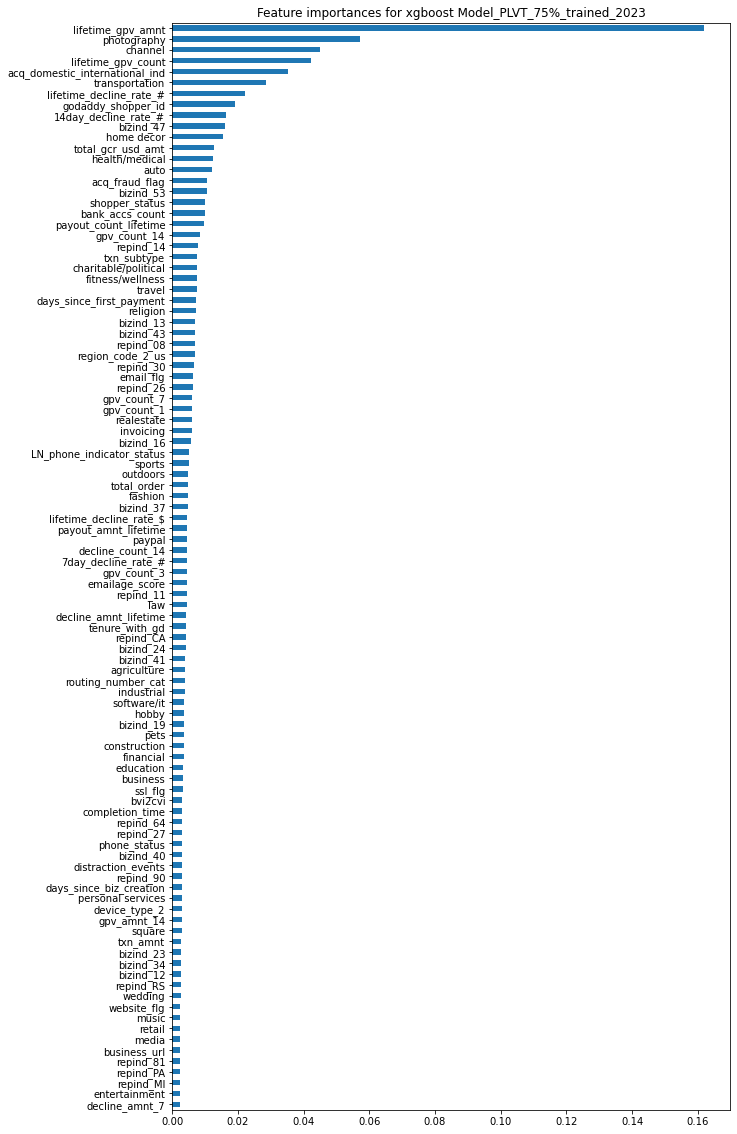

In [200]:
# plotting feature importances of the first most important 100 features
plt.figure(figsize=(10,20))

feature_importances = (pd.Series(xgb_3.feature_importances_, index=X_train.columns).sort_values(ascending=True))
feature_importances[-100:].plot(kind='barh')
plt.title("Feature importances for xgboost Model_PLVT_75%_trained_2023")

In [193]:
%%time
# calculate the precision and recall based on number of transactions, based on number of businesses, and based on transaction $ amount
# using cross validation

prob_th = 0.5

from xgboost import XGBClassifier
xgb=XGBClassifier(random_state=1, 
                  scale_pos_weight= ((y==0).sum() / (y==1).sum()),
                  max_depth=8,eta=0.14877304660190543,gamma=0.64233392053415,min_child_weight=2.8318831078097713,
                 subsample=0.7648606852831362,n_estimators=176, alpha=4.251236052084222) # no CB, balanced




# Create GroupKFold object

precision_txn = []
recall_txn = []
f1_txn = []

precision_biz = []
recall_biz = []
queue_rate_biz = []

precision_amnt = []
recall_amnt = []
queue_rate_amnt = []


n_splits = 5
gss = GroupShuffleSplit(n_splits=n_splits, test_size=0.25, random_state=1729)
for train_index, test_index in gss.split(X, y, df_ML_PLVT['business_uuid']):
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]
    
    
       
    # Fit the model
    xgb.fit(X_train, y_train)
 
    test_probs_xgb_noCB = xgb.predict_proba(X_test)
    y_pred_xgb = (test_probs_xgb_noCB[:, 1] >= prob_th)
    
    precision_txn.append(precision_score(y_test, y_pred_xgb))
    recall_txn.append(recall_score(y_test, y_pred_xgb))
    f1_txn.append(f1_score(y_test, y_pred_xgb))
    
    test_probs_xgb_s = pd.Series(test_probs_xgb_noCB[:, 1], index=y_test.index, name="Predicted_prob")
    test_pred_xgb_s = pd.Series(test_probs_xgb_s>prob_th, index=y_test.index, name="Predicted_flg")



    test_xgb_noCB = pd.concat([df_ML_PLVT.txn_uuid.loc[y_test.index], df_ML_PLVT.business_uuid.loc[y_test.index],
                  df_ML_PLVT.txn_date.loc[y_test.index],
                  X_test,
                  y_test, test_probs_xgb_s, test_pred_xgb_s], axis=1)
    
    
    df_rules = test_xgb_noCB[["txn_uuid", "Class", "Predicted_flg", "txn_date", "business_uuid", "txn_amnt", "Predicted_prob"]]

    
    txn_queue_rate = np.round(df_rules[(df_rules.Predicted_flg==1)].txn_uuid.nunique()/df_rules.txn_uuid.nunique(), 3)
    # txn_based precision 
    p_txn = np.round(df_rules[(df_rules.Predicted_flg==1) & (df_rules.Class==1)].txn_uuid.nunique()/df_rules[df_rules.Predicted_flg==1].txn_uuid.nunique(), 3)
    # txn_based reacll 
    r_txn = np.round(df_rules[(df_rules.Predicted_flg==1) & (df_rules.Class==1)].txn_uuid.nunique()/df_rules[df_rules.Class==1].txn_uuid.nunique(), 3)



    biz_queue_rate = np.round(df_rules[(df_rules.Predicted_flg==1)].business_uuid.nunique()/df_rules.business_uuid.nunique(), 3)
    # biz_based precision 
    p_biz = np.round(df_rules[(df_rules.Predicted_flg==1) & (df_rules.Class==1)].business_uuid.nunique()/df_rules[df_rules.Predicted_flg==1].business_uuid.nunique(), 3)
    # biz_based reacll 
    r_biz = np.round(df_rules[(df_rules.Predicted_flg==1) & (df_rules.Class==1)].business_uuid.nunique()/df_rules[df_rules.Class==1].business_uuid.nunique(), 3)
     
    precision_biz.append(p_biz)
    recall_biz.append(r_biz)
    queue_rate_biz.append(biz_queue_rate)

    amnt_queue_rate = np.round(df_rules[df_rules.business_uuid.isin(df_rules[(df_rules.Predicted_flg==1)].business_uuid.unique())].txn_amnt.sum()/df_rules.txn_amnt.sum(), 3)
    # amount_based precision 
    p_amnt = np.round(df_rules[df_rules.business_uuid.isin(df_rules[(df_rules.Predicted_flg==1) & (df_rules.Class==1)].business_uuid.unique())].txn_amnt.sum()/df_rules[df_rules.business_uuid.isin(df_rules[df_rules.Predicted_flg==1].business_uuid.unique())].txn_amnt.sum(), 3)
    # amount_based reacll 
    r_amnt = np.round(df_rules[df_rules.business_uuid.isin(df_rules[(df_rules.Predicted_flg==1) & (df_rules.Class==1)].business_uuid.unique())].txn_amnt.sum()/df_rules[df_rules.business_uuid.isin(df_rules[df_rules.Class==1].business_uuid.unique())].txn_amnt.sum(), 3)
    
    precision_amnt.append(p_amnt)
    recall_amnt.append(r_amnt)
    queue_rate_amnt.append(amnt_queue_rate)
    

CPU times: total: 2h 35min 19s
Wall time: 10min 42s


In [196]:
# the cross_validated performance results

print("p_txn", np.mean(precision_txn))
print("r_txn", np.mean(recall_txn))
print("f1_txn", np.mean(f1_txn))

print("p_biz", np.mean(precision_biz))
print("r_biz", np.mean(recall_biz))
print("biz_queue_rate", np.mean(queue_rate_biz))

print("p_amnt", np.mean(precision_amnt))
print("r_amnt", np.mean(recall_amnt))
print("amnt_queue_rate", np.mean(queue_rate_amnt))

p_txn 0.39638539537885825
r_txn 0.36712262300930776
f1_txn 0.37772035859264524
p_biz 0.2768
r_biz 0.5276
biz_queue_rate 0.08339999999999999
p_amnt 0.19740000000000002
r_amnt 0.2182
amnt_queue_rate 0.0274
